Nutritional-Target-Alluvial Plot
---

Using two data sources (**Intake24 data** and **Biosensors data**), extract the pathway relationships among nutritional intake, metabolic risk factors, and health outcomes, and visualize them with an Alluvial Plot.

Process:

**1.** Standardize `User ID` and map variables to three categories: Nutritional Intake → Risk Factors.  
**2.** Merge datasets by `User ID` and filter values above mean to form valid paths.  
**3.** Group by path combinations and visualize with an alluvial plot (e.g., Plotly, ggalluvial).

*   Alluvial Plot
*   Harm of diets
*   Energy drinks V.s. physical drinks




# ***To Get Start***

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/Causality/")


MessageError: Error: credential propagation was unsuccessful

# ***Data preparation****

## 1.1 Imput

In [60]:
import pandas as pd

intake = pd.read_excel('./Datasets/Real_data/CoDiet/CoDiet Intake24 Data.xlsx', sheet_name="CoDiet Intake24 Data - Tidied u")
biosensors = pd.read_csv('./Datasets/Real_data/CoDiet/biosensors.csv')

### **Intake 24**

1.  Add column 'patient', 'visit' to intake
2.  Delete or convert non_numeric columns

In [68]:
intake[['patient', 'visit']] = intake['User ID'].str.extract(r'^(CD_\d+)_?(V\d)$')
intake['patient'] = intake['patient'].str.replace('_', '-', regex=False)
intake[['User ID', 'patient', 'visit']].drop_duplicates().head()
intake['User ID'] = intake['User ID'].astype(str)
intake.to_csv('./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/intake24_cleaned.csv', sep=';', index=False)
intake.to_csv('./Datasets/Real_data/CoDiet/intake24_cleaned.csv', sep=';', index=False)

# patient num
patient_count = intake['patient'].nunique()
print(f"Patient Number Is: {patient_count}")

non_numeric_intake = intake.select_dtypes(exclude=['number']).columns
# print(non_numeric_intake)
intake

Patient Number Is: 155


,User ID,Start time,Submission time,Cooking oil used,Diet,Food amount,Reason for unusual food amount,Meal ID,Meal name,Meal time,...,Game Birds,White Fish,Oily Fish,Canned Tuna,Shellfish,Cottage Cheese,Cheddar Cheese,Other Cheese,patient,visit
0,CD_003_V1,2024-04-21T10:22:24.237Z,2024-04-21T10:37:20.542Z,Did not use,Not on a special diet,Usual,NaN,1,Breakfast,12:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD-003,V1
1,CD_003_V1,2024-04-21T10:22:24.237Z,2024-04-21T10:37:20.542Z,Did not use,Not on a special diet,Usual,NaN,1,Breakfast,12:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD-003,V1
2,CD_003_V1,2024-04-21T10:22:24.237Z,2024-04-21T10:37:20.542Z,Did not use,Not on a special diet,Usual,NaN,2,Afternoon snack or drink,16:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD-003,V1
3,CD_003_V1,2024-04-21T10:22:24.237Z,2024-04-21T10:37:20.542Z,Did not use,Not on a special diet,Usual,NaN,3,Evening meal,21:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD-003,V1
4,CD_003_V1,2024-04-21T10:22:24.237Z,2024-04-21T10:37:20.542Z,Did not use,Not on a special diet,Usual,NaN,4,Early snack or drink,14:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD-003,V1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31996,CD_106_V3,2024-10-26T17:52:04.175Z,2024-10-26T18:23:10.264Z,Olive oil,To lose weight,Usual,NaN,2,Morning snack or drink,09:45:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CD-106,V3
31997,CD_112_V3,2024-10-20T07:55:52.265Z,2024-10-20T12:59:22.340Z,Olive oil,Other: Intermittent Fasting,Usual,NaN,2,Lunch,14:30:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CD-112,V3
31998,CD_119_V3,2024-10-28T22:17:58.315Z,2024-10-28T22:33:11.457Z,Sunflower oil,Not on a special diet,Less,Don’t know,1,Breakfast,08:15:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CD-119,V3
31999,CD_139_V3,2025-01-14T22:11:27.434Z,2025-01-14T22:17:32.306Z,Did not use,Not on a special diet,Usual,NaN,2,Lunch,13:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CD-139,V3


### **Biosensors**

1.  Add column 'User ID' To biosensors

2.  Convert non_numeric columns to numeric

    *  Convert type of 'tp', 'vlf', 'lf', 'hf' as numerical data type

    *  Keep -status

    *  Remove other columns

3.  Mapping Biosensors Columns

4.  Add '-risk' columns

In [62]:
import re

# User ID, patient, visit
def clean_user_id(uid):
    uid = re.sub(r'[-]+', '_', uid)
    return uid

uid = biosensors['patient'].astype(str).apply(clean_user_id)
biosensors['User ID'] = uid + '_' + biosensors['visit'].astype(str)

# Non_numeric columns
biosensors['vfl-(visceral-fat-level)'] = [int(str(item).replace("Level", "")) if isinstance(item, str) else item for item in list(biosensors['vfl-(visceral-fat-level)'])]
cols_to_convert = ['tp', 'vlf', 'lf', 'hf']
for col in cols_to_convert:
    if col in biosensors.columns:
        biosensors[col] = pd.to_numeric(biosensors[col], errors='coerce')

#Columns have upper and lower but NO Col-name: Rename to -llimit/ulimit
rename_dict = {
    'lower-limit-(abdominal-fat-normal-range)': 'af-ll(abdominal-fat-llimit)',
    'upper-limit-(abdominal-fat-normal-range)': 'af-ul(abdominal-fat-ulimit)',
    'lower-limit-(subcutaneous-fat-of-abdomen-normal-range)': 'sfa-ll(subcutaneous-fat-of-abdomen-llimit)',
    'upper-limit-(subcutaneous-fat-of-abdomen-normal-range)': 'sfa-ul(subcutaneous-fat-of-abdomen-ulimit)'
}
biosensors = biosensors.rename(columns=rename_dict)
biosensors['bfm-of-arm-&-leg']=biosensors['bfm-of-left-leg']+biosensors['bfm-of-right-leg']+biosensors['bfm-of-left-arm']+biosensors['bfm-of-right-arm']
biosensors.to_csv('./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/biosensors_cleaned.csv', sep=';', index=False)

# patient num
patient_count = biosensors['patient'].nunique()
print(f"Patient Number Is: {patient_count}")

non_numeric_columns = biosensors.select_dtypes(exclude=['number']).columns
#print(non_numeric_columns)
biosensors

Patient Number Is: 153


,patient,visit,gender,date-of-birth,exam-date,age-value,risk-group,site,wave-type,ai,...,tbw/wt-t-score,tbw/wt-z-score,smm/wt-t-score,smm/wt-z-score,ecm/bcm-t-score,ecm/bcm-z-score,r/ht,xc/ht,User ID,bfm-of-arm-&-leg
0,CD-005,V1,Female,1968-11-25,2024-05-13 00:00:00,1.8,Normal,AUTH,Vessel Status-Level 4,-31.83,...,-0.8,-0.3,-0.8,-0.2,0.3,-0.5,351.7,33.6,CD_005_V1,14.4
1,CD-005,V2,Female,1968-11-25,2024-06-03 00:00:00,2.5,I,AUTH,Vessel Status-Level 3,-43.85,...,-0.6,-0.1,-0.7,-0.1,1.9,1.2,316.2,28.2,CD_005_V2,14.1
2,CD-005,V3,Female,1968-11-25,2024-07-01 00:00:00,2.4,I,AUTH,Vessel Status-Level 4,-36.01,...,-0.5,0.0,-0.5,0.1,1.4,0.6,322.3,29.1,CD_005_V3,13.2
3,CD-012,V1,Female,1971-06-28,2024-05-13 00:00:00,2.3,I,AUTH,Vessel Status-Level 4,-24.15,...,-2.0,-1.6,-2.0,-1.5,2.7,1.9,305.5,26.3,CD_012_V1,30.7
4,CD-012,V2,Female,1971-06-28,2024-06-03 00:00:00,2.3,I,AUTH,Vessel Status-Level 4,-35.42,...,-1.9,-1.4,-1.9,-1.4,2.0,1.2,307.4,27.3,CD_012_V2,28.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,CD-249,V1,Female,1971-06-27,2024-09-16,1.8,Normal,UVEG,Vessel Status-Level 3,-47.84,...,-1.2,-0.7,-1.1,-0.6,0.1,-0.7,344.5,34.6,CD_249_V1,18.1
445,CD-249,V2,Female,1971-06-27,2024-10-08,2.2,I,UVEG,Vessel Status-Level 4,-12.88,...,-1.2,-0.7,-1.1,-0.6,0.5,-0.3,329.3,32.9,CD_249_V2,18.5
446,CD-249,V3,Female,1971-06-27,2024-11-12,2.5,I,UVEG,Vessel Status-Level 4,-19.46,...,-1.1,-0.6,-1.0,-0.4,0.0,-0.7,339.8,34.3,CD_249_V3,17.6
447,CD-256,V1,Male,1963-06-30,2024-09-16,2.4,I,UVEG,Vessel Status-Level 3,-30.33,...,-0.5,0.4,-0.6,0.6,0.7,-1.2,284.7,31.7,CD_256_V1,7.8


## **1.2 Biosensor_Cols Matching**
Col names:
*   keyword_id: **absi-whole-body**,
*   metric_name: **absi(a-body-shaped-index)**,
*   cols_from_biosensors: **absi(a-body-shaped-index),upper-limit-(absi-normal-range)**,
*   metric_code	body_region: **whole-body**,
*   metric_description: **absi(a-body-shaped-index)**,
*   risk_field: **absi(a-body-shaped-index)_risk**,
*   data_type: **N**
*   category:	**Body Measurement**



In [63]:
import pandas as pd
import re

# STEP 1: Remove non_numeric
'''
non_numeric_biosensors = [
    col for col in biosensors.select_dtypes(exclude=['number']).columns
    if col not in ['User ID', 'patient', 'visit'] and not col.endswith('status')
]

fields = [
    col for col in biosensors.columns
    if col not in {'User ID', 'visit', 'patient', *non_numeric_biosensors}
]
'''
fields = biosensors.select_dtypes(include='number').columns.difference(['User ID', 'visit', 'patient']).union(
    biosensors.columns[biosensors.columns.str.endswith('status')]
)


# STEP 2: 特征关键词映射
keyword_aliases = {
    'visceral-fat-of-abdomen': 'vfa',
    'waist-hip-ratio': 'whr',
    'body-mass-index': 'bmi',
    'percent-body-fat': 'pbf',
    'fat-free-mass': 'ffm',
    'skeletal-muscle-mass': 'smm',
    'body-fat-mass': 'bfm',
    'total-body-water': 'tbw',
    'intracellular-water': 'icw',
    'extracellular-water': 'ecw',
    'body-cell-mass': 'bcm',
    'fat-mass-index': 'fmi',
    'fat-free-mass-index': 'ffmi',
    'skeletal-muscle-index': 'smi',
    'visceral-fat-area': 'vfa',
    'a-body-shaped-index': 'absi',
    'body-adiposity-index': 'bai',
    'subcutaneous-fat-of-abdomen': 'sfa',
    'abdominal-fat': 'af'
}

# STEP 3: 提取字段关键词
def extract_keyword(field):
    if 'ecw/tbw' in field:
        return 'ecw/tbw'

    match = re.match(r'(lower-limit|upper-limit)-\(([\w/&-]+)-normal-range\)', field)
    if match:
        raw_keyword = match.group(2)
        field = keyword_aliases.get(raw_keyword, raw_keyword.split('-of')[0])

        match = re.match(r'([\w-]+)-of-', field)
        if match:
            return match.group(1)

        match = re.match(r'([a-zA-Z0-9/-]+)-of-', field)
        if match:
            return match.group(1)

    match = re.match(r'(khz)-[\w-]+', field)
    if match:
        return match.group(1)

    match = re.match(r'([a-zA-Z0-9/-]+)-of-', field)
    if match:
        return match.group(1)

    match = re.match(r'([\w-]+)\(.*\)-of-', field)
    if match:
        return match.group(1)

    match = re.match(r'([\w-]+)%-of-', field)
    if match:
        return match.group(1)

    match = re.match(r'([\w/-]+)-(t|z)-score$', field)
    if match:
        return match.group(1)

    match = re.match(r'([\w-]+)\(.*\)-(t|z)-score$', field)
    if match:
        return match.group(1)

    match = re.match(r'([\w/-]+)-\(', field)
    if match:
        return match.group(1)

    match = re.match(r'(.*?)(norm)$', field)
    if match:
        return match.group(1)

    if field.endswith("-status"):
        return field.rsplit("-status", 1)[0]

    field = re.sub(r'\(.*?\)', '', field)
    field = re.sub(r'-\((.*?)\)', r'(\1)', field)

    return field

keywords = [extract_keyword(f) for f in fields]

# STEP 4: 创建关键词映射表
keyword_mapping_df = pd.DataFrame({
    'field_name': fields,
    'metric_code': keywords
})

# STEP 5: 添加身体部位标签
body_categories = {
    'left-arm': ['left-arm', 'khz-la'],
    'right-arm': ['right-arm', 'khz-ra'],
    'left-leg': ['left-leg', 'khz-ll'],
    'right-leg': ['right-leg', 'khz-rl'],
    'trunk': ['trunk', 'khz-tr'],
    'neck': ['neck'],
    'chest': ['chest'],
    'waist': ['waist', 'wc', 'whtr', 'whr'],
    'muscle': ['muscle', 'smm', 'smi', 'svr', 'smm/wt', 'lean-mass', 'slm'],
    'abdomen': ['abdomen', 'visceral', 'abdominal', 'whr', 'hip','vfa'],
    'right-thigh': ['right-thigh'],
    'left-thigh': ['left-thigh'],
    'bone': ['bone', 'bmc'],
    'arm&leg': ['arm-&-leg','arms/legs'],
    'arm': ['arm'],
    'leg': ['leg'],
    'heart': ['heart', 'hr', 'lf', 'hf', 'khz', 'phase-angle'],
    'whole-body': ['whole-body', 'body', 'bmi', 'pbf', 'tbw', 'bfm', 'bcm']
}

body_map = []
for field in fields:
    matched = False
    for region, keys in body_categories.items():
        if any(k in field for k in keys):
            body_map.append({'field_name': field, 'body_region': region})
            matched = True
            break
    if not matched:
        body_map.append({'field_name': field, 'body_region': 'whole-body'})

body_mapping_df = pd.DataFrame(body_map)

# STEP 6: 合并关键词和身体部位
bio_metric_table = pd.merge(keyword_mapping_df, body_mapping_df, on='field_name', how='left')
bio_metric_table['keyword_id'] = bio_metric_table['metric_code'] + '-' + bio_metric_table['body_region']

# STEP 7: 提取每个 keyword 的主代表字段
index_keywords = ['lower', 'upper', 't-score', 'z-score', 'status', 'norm']
percentage_keywords = ['(ln)', 'lean-mass(%)']

def pick_main_field(group):
    for x in group:
        if any(k in x for k in percentage_keywords):
            return x
    for x in group:
        if not any(k in x for k in index_keywords):
            return x
    return None

main_field_df = bio_metric_table.groupby('keyword_id')['field_name'].apply(pick_main_field).reset_index(name='metric_name')
metric_group_df = bio_metric_table.groupby('keyword_id')['field_name'].apply(lambda x: ','.join(x)).reset_index(name='cols_from_biosensors')

metric_summary_df = pd.merge(main_field_df, metric_group_df, on='keyword_id', how='outer')
bio_keyword_df = pd.merge(metric_summary_df, bio_metric_table, left_on=['metric_name', 'keyword_id'], right_on=['field_name', 'keyword_id'], how='left')

# STEP 8: 添加描述（字段含义）
################################################################# keyword, description, risk ########################################################################
description_map = {
    'keyword': 'description',
    'bmi': 'bmi(body-mass-index)',
    'hr': 'hr(heart-rate)',
    'svr': 'svr(skeletal-muscle-mass-visceral-fat-area-ratio)',
    'lf/hf': 'lf/hf(ratio)',
    'local-id': 'local-id',
    'ecm/bcm': 'ecm/bcm(body-cell-mass)',
    'ecw/tbw': 'ecw/tbw(total-body-water-ratio)',
    'age': 'age',
    'ae': 'ae(activity-exercise)',
    'measure-sensor': 'measure-sensor',
    'smm/wt': 'smm/wt(skeletal-muscle-mass-to-weight)',
    'target-weight': 'target-weight',
    'absi': 'absi(a-body-shaped-index)',
    'smm': 'smm(skeletal-muscle-mass)',
    'fmi': 'fmi(fat-mass-index)',
    'vlf': 'vlf(very-low-frequency)',
    'recommended-calorie-intake': 'recommended-calorie-intake',
    'r/ht': 'r/ht(ratio)',
    'amc': 'amc(arm-muscle-circumference)',
    'measured-circumference': 'measured-circumference',
    'tbw/ffm': 'tbw/ffm(total-body-water-to-fat-free-mass-ratio)',
    'af-ll': 'af-ll(abdominal-fat-lower-limit)',
    'af-ul': 'af-ul(abdominal-fat-upper-limit)',
    'stress-resilience': 'stress-resilience',
    'protein': 'protein',
    'bfm': 'bfm(body-fat-mass)',
    'ffm': 'ffm(fat-free-mass)',
    'lf': 'lf(low-frequency)',
    'hf': 'hf(high-frequency)',
    'height': 'height',
    'pe': 'pe(peripheral-fat)',
    'tsrd': 'tsrd(time-series-resilience-degree)',
    'obesity-degree': 'obesity-degree',
    'rmssd': 'rmssd(root-mean-square-of-successive-differences)',
    'ans-activity': 'ans-activity(autonomic-nervous-system-activity)',
    'smi': 'smi(skeletal-muscle-index)',
    'ffm-control': 'ffm-control(fat-free-mass-control)',
    'icw': 'icw(intracellular-water)',
    'fatigue-index': 'fatigue-index',
    'lean-mass': 'lean-mass',
    'tbw/wt': 'tbw/wt(total-body-water-to-weight-ratio)',
    'ans-balance': 'ans-balance(autonomic-nervous-system-balance)',
    'whr': 'whr(waist-hip-ratio)',
    'sfa-ll': 'sfa-ll(subcutaneous-fat-of-abdomen-lower-limit)',
    'sfa-ul': 'sfa-ul(subcutaneous-fat-of-abdomen-upper-limit)',
    'xc/ht': 'xc/ht(ratio)',
    'sdnn': 'sdnn(std-dev-of-normal-to-normal-interval)',
    'bmr': 'bmr(basal-metabolic-rate)',
    'weight': 'weight',
    'bcm': 'bcm(body-cell-mass)',
    'slm': 'slm(soft-lean-mass)',
    'khz': 'khz(phase-angle)',
    'bmc': 'bmc(bone-mineral-content)',
    'ddrcomment': 'ddrcomment',
    'bai': 'bai(body-adiposity-index)',
    'bfm-control': 'bfm-control(body-fat-mass-control)',
    'inbody-type': 'inbody-type',
    'apgcomment': 'apgcomment',
    'tp': 'tp(tissue-phase)',
    'apen': 'apen',
    'electro-cardiac-stability': 'electro-cardiac-stability',
    'pbf': 'pbf(percent-body-fat)',
    'stress-index': 'stress-index',
    'minerals': 'minerals',
    'ectopic-beat': 'ectopic-beat',
    'vfa': 'vfa(visceral-fat-of-abdomen)',
    'ecw': 'ecw(extracellular-water)',
    'wc\xa0': 'wc(waist-circumference)',
    'ai': 'ai(activity-index)',
    'ac': 'ac(arm-circumference)',
    'vfl': 'vfl(visceral-fat-level)',
    'mean-hrt': 'mean-hrt(mean-heart-rate)',
    'ffmi': 'ffmi(fat-free-mass-index)',
    'conicity-index': 'conicity-index',
    'weight-control': 'weight-control',
    'whtr': 'whtr(waist-height-ratio)',
    'inbody-score': 'inbody-score',
    'tbw': 'tbw(total-body-water)',
    'psi': 'psi(phase-angle)',
    'srd': 'srd',
    'arms/legs-fat': 'arms/legs-fat'
}
description_df = pd.DataFrame(list(description_map.items()), columns=['metric_code', 'metric_description'])

# STEP 9: 合并最终结果
bio_col_matching = pd.merge(bio_keyword_df, description_df, on='metric_code', how='left')
bio_col_matching['risk_field'] = bio_col_matching['metric_name'] + '_risk'

# STEP 10: 重命名并导出
bio_col_matching = bio_col_matching[[
    'keyword_id',
    'metric_name',
    'cols_from_biosensors',
    'metric_code',
    'body_region',
    'metric_description',
    'risk_field'
]]

# bio_col_matching.to_csv("./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/bio_col_matching.csv", index=False)
# STEP 11: 添加数据类型
def get_dtype(row):
    # 如果 cols_from_biosensors 中包含 "status"，强制为 Character
    if 'status' in row['cols_from_biosensors']:
        return 'C'
    field = row['metric_name']
    if field in biosensors.columns:
        if pd.api.types.is_numeric_dtype(biosensors[field]):
            return 'N'
        else:
            return 'C'
    return 'C'

bio_col_matching['data_type'] = bio_col_matching.apply(get_dtype, axis=1)
bio_col_matching.to_csv("./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/bio_col_matching.csv", index=False)
bio_col_matching.head()

,keyword_id,metric_name,cols_from_biosensors,metric_code,body_region,metric_description,risk_field,data_type
0,absi-whole-body,absi(a-body-shaped-index),"absi(a-body-shaped-index),upper-limit-(absi-no...",absi,whole-body,absi(a-body-shaped-index),absi(a-body-shaped-index)_risk,N
1,ac-arm,ac-(arm-circumference),ac-(arm-circumference),ac,arm,ac(arm-circumference),ac-(arm-circumference)_risk,N
2,ae-whole-body,ae,"ae,ae-status",ae,whole-body,ae(activity-exercise),ae_risk,C
3,af-ll-abdomen,af-ll(abdominal-fat-llimit),af-ll(abdominal-fat-llimit),af-ll,abdomen,af-ll(abdominal-fat-lower-limit),af-ll(abdominal-fat-llimit)_risk,N
4,af-ul-abdomen,af-ul(abdominal-fat-ulimit),af-ul(abdominal-fat-ulimit),af-ul,abdomen,af-ul(abdominal-fat-upper-limit),af-ul(abdominal-fat-ulimit)_risk,N


### **Add Category Columns**

In [64]:
from collections import defaultdict

keyword_to_category = {
    'Body Composition': ['bmi', 'smm', 'ffm', 'slm', 'smm/wt', 'tbw/ffm', 'ecm/bcm', 'ecw/tbw', 'tbw/wt', 'icw', 'lean-mass', 'bcm', 'bmc', 'inbody-type', 'inbody-score','height', 'weight', 'age', 'target-weight'],
    'Muscle Mass': ['smm', 'smi', 'smm/wt', 'smm-control'],
    'Water and Hydration': ['tbw', 'icw', 'ecw', 'tbw/ffm', 'ecw/tbw', 'tbw/wt'],
    'Fat Mass': ['bfm', 'pbf', 'fmi', 'vfl', 'arms/legs-fat', 'whr', 'wc', 'sfa', 'conicity-index'],
    'Metabolism and Energy': ['bmr', 'recommended-calorie-intake', 'protein','ae'],
    'Body Measurement': ['ac', 'amc', 'measured-circumference', 'arm-circumference', 'absi', 'xc/ht', 'whr', 'r/ht', 'whtr'],
    'Health and Risk Factors': ['local-id', 'ddrcomment', 'apgcomment', 'ai', 'minerals', 'protein', 'hf'],
    'Obesity': ['af', 'vfa', 'obesity-degree', 'bai', 'bfm','obesity', 'svr', 'fat','pe'],
    'Mental Health': ['stress-resilience', 'stress-index', 'fatigue-index', 'tsrd', 'ans-balance', 'ans-activity', 'rmssd', 'sdnn', 'mean-hrt', 'bmr','srd','lf/hf','ans'],
    'Heart': ['lf', 'hr', 'mean-hrt', 'rmssd', 'sdnn', 'electro-cardiac-stability', 'ectopic-beat','psi', 'lf/hf', 'vlf', 'khz', 'tp', 'apen'],
    'Uncategorized': []
}

def get_category(metric_code):
    # 取 - 前部分并转小写
    key = metric_code.strip().lower()
    for category, keywords in keyword_to_category.items():
        # keywords 里的 kw 全部小写比较，判断是否任一 kw 是 key 的子串
        if any(kw.lower() in key for kw in keywords):
            return category
    return 'Uncategorized'

'''
################################ 不重复分类 #############################
risk_mapping = {}
for k in keyword_to_category:
    risk_mapping[k] = []

for keyword in fields:
    found = False
    for category, kw_list in keyword_to_category.items():
        if any(kw.lower() in keyword.lower() for kw in kw_list):
            risk_mapping[category].append(keyword)
            found = True
            break
    if not found:
        risk_mapping['Uncategorized'].append(keyword)
print(risk_mapping['Uncategorized'])

if 'Uncategorized' in risk_mapping:
    del risk_mapping['Uncategorized']
risk_mapping

############################### 重复分类 #################################
risk_mapping = defaultdict(list)
fields = list(biosensors.columns)

# 遍历每个字段
for keyword in fields:
    matched = False
    for category, kw_list in keyword_to_category.items():
        if any(kw.lower() in keyword.lower() for kw in kw_list):
            risk_mapping[category].append(keyword)
            matched = True
    if not matched:
        risk_mapping['Uncategorized'].append(keyword)
'''

bio_col_matching['category'] = bio_col_matching['metric_code'].apply(get_category)
bio_col_matching.to_csv("./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/bio_col_matching.csv", index=False)


In [30]:
bio_col_matching

,keyword_id,metric_name,cols_from_biosensors,metric_code,body_region,metric_description,risk_field,data_type,category
0,absi-whole-body,absi(a-body-shaped-index),"absi(a-body-shaped-index),upper-limit-(absi-no...",absi,whole-body,absi(a-body-shaped-index),absi(a-body-shaped-index)_risk,N,Body Measurement
1,ac-arm,ac-(arm-circumference),ac-(arm-circumference),ac,arm,ac(arm-circumference),ac-(arm-circumference)_risk,N,Body Measurement
2,ae-whole-body,ae,"ae,ae-status",ae,whole-body,ae(activity-exercise),ae_risk,C,Metabolism and Energy
3,af-ll-abdomen,af-ll(abdominal-fat-llimit),af-ll(abdominal-fat-llimit),af-ll,abdomen,af-ll(abdominal-fat-lower-limit),af-ll(abdominal-fat-llimit)_risk,N,Obesity
4,af-ul-abdomen,af-ul(abdominal-fat-ulimit),af-ul(abdominal-fat-ulimit),af-ul,abdomen,af-ul(abdominal-fat-upper-limit),af-ul(abdominal-fat-ulimit)_risk,N,Obesity
...,...,...,...,...,...,...,...,...,...
115,weight-control-whole-body,weight-control,weight-control,weight-control,whole-body,weight-control,weight-control_risk,N,Body Composition
116,weight-whole-body,weight,"lower-limit-(weight-normal-range),upper-limit-...",weight,whole-body,weight,weight_risk,N,Body Composition
117,whr-waist,whr-(waist-hip-ratio),"lower-limit-(whr-normal-range),upper-limit-(wh...",whr,waist,whr(waist-hip-ratio),whr-(waist-hip-ratio)_risk,N,Fat Mass
118,whtr-waist,whtr(waist-height-ratio),"upper-limit-(whtr-normal-range),whtr(waist-hei...",whtr,waist,whtr(waist-height-ratio),whtr(waist-height-ratio)_risk,N,Body Measurement


## **1.3 Data Dictionary**

### **Nutritional Mappings**

In [65]:
# Map to nutritional targets
nutritional_mapping = {
    'Cholesterol Fat': ['Cholesterol'],
    'Fat': ['Fat', 'Satd FA', 'Cis-Mon FA', 'Cis-n3 FA', 'Cis-n6 FA', 'Trans FA'],
    'FV': ['Tomatoes', 'Tomato puree', 'Brassicaceae', 'Yellow Red Green', 'Beans', 'Other Vegetables', 'Vegetable Puree', 'FS Vegetable Puree', 'Fruit', 'Vegetables'],
    'Sugar/SSBs': ['Total sugars', 'Non-milk extrinsic sugars', 'Intrinsic and milk sugars', 'Glucose',
                'Fructose', 'Maltose', 'Lactose', 'Sucrose', 'Other sugars (UK)', 'FS Table sugar',
                'FS Other Added Sugar', 'FS Honey', 'FS Fruit Juice', 'Fruit Juice', 'FS Dried Fruit',
                'FS Fruit Puree', 'FS Stewed Fruit'],
    'Red/processed meat': ['Processed Red Meat', 'Beef', 'Lamb', 'Pork', 'Other Red Meat', 'Burgers',
                  'Sausages', 'Offal', 'Processed Poultry', 'Ham'],
    'Salt/sodium': ['Sodium', 'Chloride'],
    'Vitamins': ['Vitamin A', 'Retinol', 'Total carotene', 'Alpha-carotene', 'Beta-carotene',
                'Beta cryptoxanthin', 'Vitamin C', 'Vitamin D', 'Vitamin E', 'Thiamin',
                'Riboflavin', 'Niacin', 'Vitamin B6', 'Vitamin B12', 'Folate',
                'Pantothenic acid', 'Biotin', 'Niacin equivalent'],
    'Minerals': ['Potassium', 'Magnesium', 'Phosphorus', 'Calcium', 'Iron',
                'Haem iron', 'Non-haem iron', 'Zinc', 'Copper', 'Iodine',
                'Selenium', 'Manganese', 'Chloride'],
    'Amino Acids / Protein Quality': ['Protein', 'Total nitrogen', 'Nitrogen conversion factor', 'Tryptophan/60'],
    'Energy & Macronutrients': ['Energy (kcal)', 'Energy (kJ)', 'Fat', 'Protein', 'Carbohydrate', 'Alcohol'],
    'Fibre': ['Englyst fibre', 'AOAC'],
}

mapping_df = pd.DataFrame([
    {'category': category, 'metric_name': metric}
    for category, metrics in nutritional_mapping.items()
    for metric in metrics
])

print(mapping_df)

                   category    metric_name
0           Cholesterol Fat    Cholesterol
1                       Fat            Fat
2                       Fat        Satd FA
3                       Fat     Cis-Mon FA
4                       Fat      Cis-n3 FA
..                      ...            ...
84  Energy & Macronutrients        Protein
85  Energy & Macronutrients   Carbohydrate
86  Energy & Macronutrients        Alcohol
87                    Fibre  Englyst fibre
88                    Fibre           AOAC

[89 rows x 2 columns]


In [66]:
data_dictionary = pd.concat([bio_col_matching[['category', 'metric_name']], mapping_df])
data_dictionary.to_csv("./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/data_dictionary.csv", index=False)
data_dictionary


,category,metric_name
0,Body Measurement,absi(a-body-shaped-index)
1,Body Measurement,ac-(arm-circumference)
2,Metabolism and Energy,ae
3,Obesity,af-ll(abdominal-fat-llimit)
4,Obesity,af-ul(abdominal-fat-ulimit)
...,...,...
84,Energy & Macronutrients,Protein
85,Energy & Macronutrients,Carbohydrate
86,Energy & Macronutrients,Alcohol
87,Fibre,Englyst fibre


##   **1.3 Add Risk Columns**

In [69]:
import pandas as pd
import numpy as np
from copy import deepcopy

def generate_biosensor_risks(
    biosensors: pd.DataFrame,
    bio_col_matching: pd.DataFrame,
    output_path_1: str = "./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/biosensors_cleaned_withRisks.csv",
    output_path_2: str = "./Datasets/Real_data/CoDiet/biosensors.csv",
    sep: str = ';'
) -> pd.DataFrame:
    """
    根据 biosensors 数据与 bio_col_matching 映射表，生成 *_risk 列，
    并导出两个 CSV 文件。

    参数:
        biosensors (pd.DataFrame): 原始生物传感器数据。
        bio_col_matching (pd.DataFrame): 包含 'metric_name' 与 'cols_from_biosensors' 的映射表。
        output_path_1 (str): 输出路径1（清洗后的结果）。
        output_path_2 (str): 输出路径2（标准化数据保存）。
        sep (str): CSV 分隔符（默认 ';'）。

    返回:
        pd.DataFrame: 包含生成的 *_risk 列的新 DataFrame。
    """

    risk_col = {}
    biosensors_df_temp = deepcopy(biosensors)

    # 仅保留在 biosensors 中存在的指标列
    potential_indicators = [
        row['metric_name'] for _, row in bio_col_matching.iterrows()
        if row['metric_name'] in biosensors_df_temp.columns and not row['metric_name'].endswith('-status')
    ]

    for indicator in potential_indicators:
        risk_name = f"{indicator}_risk"
        matching_row = bio_col_matching[bio_col_matching['metric_name'] == indicator]

        if not matching_row.empty:
            index_name_str = matching_row.iloc[0]['cols_from_biosensors']
            index_name = set(index_name_str.split(","))

            lower, upper, t_score, z_score, status_col = None, None, None, None, None

            for col in index_name:
                col = col.strip()
                if 'lower' in col and col in biosensors_df_temp.columns:
                    lower = col
                elif 'upper' in col and col in biosensors_df_temp.columns:
                    upper = col
                elif 't-score' in col and col in biosensors_df_temp.columns:
                    t_score = col
                elif 'z-score' in col and col in biosensors_df_temp.columns:
                    z_score = col
                elif ('status' in col or 'level' in col) and col in biosensors_df_temp.columns:
                    status_col = col

            high_condition = None

            if lower and upper and t_score and z_score:
                high_condition = (
                    (biosensors_df_temp[indicator] < biosensors_df_temp[lower]) |
                    (biosensors_df_temp[indicator] > biosensors_df_temp[upper]) |
                    (biosensors_df_temp[t_score] > 1.5) |
                    (biosensors_df_temp[z_score] > 1.5)
                )
            elif lower and upper:
                high_condition = (
                    (biosensors_df_temp[indicator] < biosensors_df_temp[lower]) |
                    (biosensors_df_temp[indicator] > biosensors_df_temp[upper])
                )
            elif upper:
                high_condition = (biosensors_df_temp[indicator] > biosensors_df_temp[upper])
            elif t_score and z_score:
                high_condition = (
                    (biosensors_df_temp[t_score] > 1.5) |
                    (biosensors_df_temp[z_score] > 1.5)
                )
            elif status_col:
                high_condition = (
                    ~biosensors_df_temp[status_col].isin(
                        ['Normal', 'Optimal', 'Good', 'Excellent', 'Balanced']
                    )
                )
            elif indicator in biosensors_df_temp.columns:
                mean_vals = biosensors_df_temp[indicator].mean()
                if indicator in ['af-ll(abdominal-fat-llimit)', 'sfa-ll(subcutaneous-fat-of-abdomen-llimit)']:
                    high_condition = (biosensors_df_temp[indicator] < mean_vals)
                else:
                    high_condition = (biosensors_df_temp[indicator] > mean_vals)

            if high_condition is not None:
                risk_col[risk_name] = np.where(high_condition, 'high', 'low')

    biosensors_risk = pd.concat(
        [biosensors_df_temp, pd.DataFrame(risk_col, index=biosensors_df_temp.index)],
        axis=1
    )

    # 导出结果
    biosensors_risk.to_csv(output_path_1, index=False, sep=sep)
    biosensors_risk.to_csv(output_path_2, index=False, sep=sep)

    # 输出统计信息
    patient_count = biosensors_risk['patient'].nunique()
    print(f"Generated {len(risk_col)} risk columns.")
    print(f"Patient Number: {patient_count}")
    print(f"Saved to:\n - {output_path_1}\n - {output_path_2}")

    return biosensors_risk

biosensors_risk = generate_biosensor_risks(
    biosensors,
    bio_col_matching,
    output_path_1="./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/biosensors_cleaned_withRisks.csv",
    output_path_2="./Datasets/Real_data/CoDiet/biosensors_cleaned_withRisks.csv",
    sep=';'
)

✅ Generated 120 risk columns.
👩‍⚕️ Patient Number: 153
💾 Saved to:
 - ./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/biosensors_cleaned_withRisks.csv
 - ./Datasets/Real_data/CoDiet/biosensors.csv


# ***Literature Review Analysis***


## **2.1 Data loader**

In [46]:
import pandas as pd

intake24 = pd.read_csv('./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/intake24_cleaned.csv', sep=';',low_memory=False)
biosensors = pd.read_csv('./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/biosensors_cleaned_withRisks.csv', sep=';', low_memory=False)
#biosensors = pd.read_csv('./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/bio_col_matching.csv', sep=';', low_memory=False)
category_dict = pd.read_csv('./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/data_dictionary.csv', sep=';', low_memory=False)
print(intake24.shape, biosensors.shape)

(32001, 133) (449, 404)


## **2.2 Mapping Dictionary**

### **Risk Mappings**

In [52]:
from collections import defaultdict

# Nutritional categories
nutritional_category = [
    'Cholesterol Fat', 'Fat', 'FV', 'Sugar/SSBs', 'Red/processed meat',
    'Salt/sodium', 'Vitamins', 'Minerals',
    'Amino Acids / Protein Quality', 'Energy & Macronutrients', 'Fibre'
]

# 区分 intake (营养类) 与 bio (生物类)
intake_col_matching = data_dictionary.query("category in @nutritional_category")
bio_col_matching = data_dictionary.query("category not in @nutritional_category")

# --- 构建营养类别映射 ---
risk_mapping = defaultdict(list)
for _, row in intake_col_matching.iterrows():
    category = row['category']
    metric_name = row['metric_name']
    risk_mapping[category].append(metric_name)
risk_mapping = dict(risk_mapping)

# 打印营养类别
print("=== Nutritional Mapping ===")
for cat, metrics in risk_mapping.items():
    print(f"'{cat}': {metrics}\n")

# --- 构建生物信号类别映射 ---
nutritional_mapping = defaultdict(list)
for _, row in bio_col_matching.iterrows():
    category = row['category']
    metric_name = row['metric_name']
    nutritional_mapping[category].append(metric_name)
nutritional_mapping = dict(nutritional_mapping)

# 打印生物信号类别
print("\n=== Risk Mapping ===")
for cat, metrics in nutritional_mapping.items():
    print(f"'{cat}': {metrics}\n")


=== Nutritional Mapping ===
'Cholesterol Fat': ['Cholesterol']

'Fat': ['Fat', 'Satd FA', 'Cis-Mon FA', 'Cis-n3 FA', 'Cis-n6 FA', 'Trans FA']

'FV': ['Tomatoes', 'Tomato puree', 'Brassicaceae', 'Yellow Red Green', 'Beans', 'Other Vegetables', 'Vegetable Puree', 'FS Vegetable Puree', 'Fruit', 'Vegetables']

'Sugar/SSBs': ['Total sugars', 'Non-milk extrinsic sugars', 'Intrinsic and milk sugars', 'Glucose', 'Fructose', 'Maltose', 'Lactose', 'Sucrose', 'Other sugars (UK)', 'FS Table sugar', 'FS Other Added Sugar', 'FS Honey', 'FS Fruit Juice', 'Fruit Juice', 'FS Dried Fruit', 'FS Fruit Puree', 'FS Stewed Fruit']

'Red/processed meat': ['Processed Red Meat', 'Beef', 'Lamb', 'Pork', 'Other Red Meat', 'Burgers', 'Sausages', 'Offal', 'Processed Poultry', 'Ham']

'Salt/sodium': ['Sodium', 'Chloride']

'Vitamins': ['Vitamin A', 'Retinol', 'Total carotene', 'Alpha-carotene', 'Beta-carotene', 'Beta cryptoxanthin', 'Vitamin C', 'Vitamin D', 'Vitamin E', 'Thiamin', 'Riboflavin', 'Niacin', 'Vitamin B

### **Count**

In [53]:
## Count category
category_counts_inter = bio_col_matching['category'].value_counts().reset_index()
category_counts_inter.columns = ['Intermediate Risks', 'Intermediate_Risk_Count']
print(category_counts_inter)

category_counts_diet = {
    "Dietary Risks": [],
    "Dietary_Risk_Count": []
}
for category, items in nutritional_mapping.items():
    category_counts_diet["Dietary Risks"].append(category)
    category_counts_diet["Dietary_Risk_Count"].append(len(items))
category_counts_diet = pd.DataFrame(category_counts_diet)
category_counts_diet


        Intermediate Risks  Intermediate_Risk_Count
0         Body Composition                       37
1                 Fat Mass                       17
2         Body Measurement                       15
3                    Heart                       12
4      Water and Hydration                       12
5                  Obesity                        8
6            Mental Health                        8
7  Health and Risk Factors                        6
8    Metabolism and Energy                        4
9              Muscle Mass                        1


,Dietary Risks,Dietary_Risk_Count
0,Body Measurement,15
1,Metabolism and Energy,4
2,Obesity,8
3,Body Composition,37
4,Health and Risk Factors,6
5,Mental Health,8
6,Fat Mass,17
7,Heart,12
8,Water and Hydration,12
9,Muscle Mass,1


### **Plot Mappings**

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import textwrap
import re

def create_graph(title, nutritional_mapping, fixed_pos, radii,  node_size_cate, node_size_item):
    G = nx.DiGraph()
    pos = fixed_pos.copy()
    for category, items in nutritional_mapping.items():
        if not G.has_node(category):  # Check if category node already exists
            G.add_node(category)  # Add the category node

        for item in items:
            if not G.has_node(item):  # Check if item node already exists
                G.add_node(item)  # Add the item node
            G.add_edge(category, item)  # Add edges from category to item

    index =0
    for category, items in nutritional_mapping.items():
        category_pos = pos[category]  # Fixed position for the category
        radius = radii[index]  # Radius for items around each category
        # print(f'{category} {radius}')
        index+=1
        # Position items around each category node in a circle
        for i, item in enumerate(items):
            angle = 2 * np.pi * i / len(items)  # Angle for each item node
            pos[item] = (category_pos[0] + radius * np.cos(angle), category_pos[1] + radius * np.sin(angle))

    def break_text(text, width=7):
        # 1. 按符号分割
        parts = re.split(r'[\"\'\(\)\-_]', text)
        parts = [p.strip() for p in parts if p.strip()]  # 去除空串

        # 2. 对每个部分再进行自动换行（按最大字数）
        wrapped_lines = []
        for part in parts:
            wrapped = textwrap.wrap(part, width=width)
            wrapped_lines.extend(wrapped)

        # 3. 用换行符拼接
        return '\n'.join(wrapped_lines)

    plt.figure(figsize=(20, 18))
    nx.draw_networkx_nodes(G, pos, nodelist=nutritional_mapping.keys(), node_size=node_size_cate, node_color='skyblue', edgecolors='black', linewidths=1.5)
    item_nodes = [node for node in G.nodes if node not in nutritional_mapping.keys()]
    nx.draw_networkx_nodes(G, pos, nodelist=item_nodes, node_size= node_size_item, node_color='white', node_shape='H', edgecolors='black', linewidths=1.5)

    nx.draw_networkx_edges(G, pos, edge_color='black', min_target_margin=20, connectionstyle='arc3,rad=0.0', width=1)
    labels = {node: break_text(node) for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

    plt.axis('off')
    #plt.title("Demonstration of Causality Predicted from DBN", fontsize=12)
    plt.tight_layout()
    plt.savefig(f'./Results/ExDBN-NutritionalData/CoDiet-Intake24-Biosensor-plots/{title}_plot.png')
    plt.savefig(f'./Results/ExDBN-NutritionalData/CoDiet-Intake24-Biosensor-plots/{title}_plot.pdf', format='pdf')
    plt.show()

In [ ]:
# Map to nutritional targets
nutritional_mapping = {
    'Cholesterol Fat': ['Cholesterol'],
    'Fat': ['Fat', 'Satd FA', 'Cis-Mon FA', 'Cis-n3 FA', 'Cis-n6 FA', 'Trans FA'],
    'FV': ['Tomatoes', 'Tomato puree', 'Brassicaceae', 'Yellow Red Green', 'Beans', 'Other Vegetables', 'Vegetable Puree', 'FS Vegetable Puree', 'Fruit', 'Vegetables'],
    'Sugar/SSBs': ['Total sugars', 'Non-milk extrinsic sugars', 'Intrinsic and milk sugars', 'Glucose',
                'Fructose', 'Maltose', 'Lactose', 'Sucrose', 'Other sugars (UK)', 'FS Table sugar',
                'FS Other Added Sugar', 'FS Honey', 'FS Fruit Juice', 'Fruit Juice', 'FS Dried Fruit',
                'FS Fruit Puree', 'FS Stewed Fruit'],
    'Red/processed meat': ['Processed Red Meat', 'Beef', 'Lamb', 'Pork', 'Other Red Meat', 'Burgers',
                  'Sausages', 'Offal', 'Processed Poultry', 'Ham'],
    'Salt/sodium': ['Sodium', 'Chloride'],
    'Vitamins': ['Vitamin A', 'Retinol', 'Total carotene', 'Alpha-carotene', 'Beta-carotene',
                'Beta cryptoxanthin', 'Vitamin C', 'Vitamin D', 'Vitamin E', 'Thiamin',
                'Riboflavin', 'Niacin', 'Vitamin B6', 'Vitamin B12', 'Folate',
                'Pantothenic acid', 'Biotin', 'Niacin equivalent'],
    'Minerals': ['Potassium', 'Magnesium', 'Phosphorus', 'Calcium', 'Iron',
                'Haem iron', 'Non-haem iron', 'Zinc', 'Copper', 'Iodine',
                'Selenium', 'Manganese', 'Chloride'],
    'Amino Acids / Protein Quality': ['Protein', 'Total nitrogen', 'Nitrogen conversion factor', 'Tryptophan/60'],
    'Energy & Macronutrients': ['Energy (kcal)', 'Energy (kJ)', 'Fat', 'Protein', 'Carbohydrate', 'Alcohol'],
    'Fibre': ['Englyst fibre', 'AOAC'],
}

# Map to intermediate risk factors
risk_mapping = {
    'Body Composition': ['age-value', 'height', 'age', 'weight', 'lower-limit-(weight-normal-range)', 'upper-limit-(weight-normal-range)', 'icw-(intracellular-water)', 'lower-limit-(icw-normal-range)', 'upper-limit-(icw-normal-range)', 'slm-(soft-lean-mass)', 'lower-limit-(slm-normal-range)', 'upper-limit-(slm-normal-range)', 'ffm-(fat-free-mass)', 'lower-limit-(ffm-normal-range)', 'upper-limit-(ffm-normal-range)', 'smm-(skeletal-muscle-mass)', 'lower-limit-(smm-normal-range)', 'upper-limit-(smm-normal-range)', 'bmi-(body-mass-index)', 'lower-limit-(bmi-normal-range)', 'upper-limit-(bmi-normal-range)', 'lean-mass-of-right-arm', 'lower-limit-(lean-mass-of-right-arm-normal-range)', 'upper-limit-(lean-mass-of-right-arm-normal-range)', 'lean-mass(%)-of-right-arm', 'lean-mass-of-left-arm', 'lower-limit-(lean-mass-of-left-arm-normal-range)', 'upper-limit-(lean-mass-of-left-arm-normal-range)', 'lean-mass(%)-of-left-arm', 'lean-mass-of-trunk', 'lower-limit-(lean-mass-of-trunk-normal-range)', 'upper-limit-(lean-mass-of-trunk-normal-range)', 'lean-mass(%)-of-trunk', 'lean-mass-of-right-leg', 'lower-limit-(lean-mass-of-right-leg-normal-range)', 'upper-limit-(lean-mass-of-right-leg-normal-range)', 'lean-mass(%)-of-right-leg', 'lean-mass-of-left-leg', 'lower-limit-(lean-mass-of-left-leg-normal-range)', 'upper-limit-(lean-mass-of-left-leg-normal-range)', 'lean-mass(%)-of-left-leg', 'icw-of-right-arm', 'lower-limit-(icw-of-right-arm-normal-range)', 'upper-limit-(icw-of-right-arm-normal-range)', 'icw-of-left-arm', 'lower-limit-(icw-of-left-arm-normal-range)', 'upper-limit-(icw-of-left-arm-normal-range)', 'icw-of-trunk', 'lower-limit-(icw-of-trunk-normal-range)', 'upper-limit-(icw-of-trunk-normal-range)', 'icw-of-right-leg', 'lower-limit-(icw-of-right-leg-normal-range)', 'upper-limit-(icw-of-right-leg-normal-range)', 'icw-of-left-leg', 'lower-limit-(icw-of-left-leg-normal-range)', 'upper-limit-(icw-of-left-leg-normal-range)', 'ecw/tbw', 'ecw/tbw-of-right-arm', 'ecw/tbw-of-left-arm', 'ecw/tbw-of-trunk', 'ecw/tbw-of-right-leg', 'ecw/tbw-of-left-leg', 'inbody-score', 'target-weight', 'weight-control', 'ffm-control', 'bcm-(body-cell-mass)', 'lower-limit-(bcm-normal-range)', 'upper-limit-(bcm-normal-range)', 'bmc-(bone-mineral-content)', 'lower-limit-(bmc-normal-range)', 'upper-limit-(bmc-normal-range)', 'tbw/ffm', 'ffmi-(fat-free-mass-index)', 'inbody-type', 'whole-body-ecw/tbw-t-score', 'whole-body-ecw/tbw-z-score', 'bmi-t-score', 'bmi-z-score', 'whtr(waist-height-ratio)', 'smm/wt', 'ecm/bcm', 'tbw/wt', 'bcm-t-score', 'bcm-z-score', 'ffmi-t-score', 'ffmi-z-score', 'weight-t-score', 'weight-z-score', 'tbw/wt-t-score', 'tbw/wt-z-score', 'smm/wt-t-score', 'smm/wt-z-score', 'ecm/bcm-t-score', 'ecm/bcm-z-score'],
    'Obesity': ['wave-type', 'pe', 'pe-status', 'fatigue-index', 'fatigue-index-status', 'apen', 'upper-limit-(weight-normal-range)', 'upper-limit-(tbw-normal-range)', 'upper-limit-(icw-normal-range)', 'upper-limit-(ecw-normal-range)', 'upper-limit-(protein-normal-range)', 'upper-limit-(minerals-normal-range)', 'bfm-(body-fat-mass)', 'lower-limit-(bfm-normal-range)', 'upper-limit-(bfm-normal-range)', 'upper-limit-(slm-normal-range)', 'ffm-(fat-free-mass)', 'upper-limit-(ffm-normal-range)', 'upper-limit-(smm-normal-range)', 'upper-limit-(bmi-normal-range)', 'pbf-(percent-body-fat)', 'upper-limit-(pbf-normal-range)', 'upper-limit-(lean-mass-of-right-arm-normal-range)', 'upper-limit-(lean-mass-of-left-arm-normal-range)', 'upper-limit-(lean-mass-of-trunk-normal-range)', 'upper-limit-(lean-mass-of-right-leg-normal-range)', 'upper-limit-(lean-mass-of-left-leg-normal-range)', 'upper-limit-(tbw-of-right-arm-normal-range)', 'upper-limit-(tbw-of-left-arm-normal-range)', 'upper-limit-(tbw-of-trunk-normal-range)', 'upper-limit-(tbw-of-right-leg-normal-range)', 'upper-limit-(tbw-of-left-leg-normal-range)', 'upper-limit-(icw-of-right-arm-normal-range)', 'upper-limit-(icw-of-left-arm-normal-range)', 'upper-limit-(icw-of-trunk-normal-range)', 'upper-limit-(icw-of-right-leg-normal-range)', 'upper-limit-(icw-of-left-leg-normal-range)', 'upper-limit-(ecw-of-right-arm-normal-range)', 'upper-limit-(ecw-of-left-arm-normal-range)', 'upper-limit-(ecw-of-trunk-normal-range)', 'upper-limit-(ecw-of-right-leg-normal-range)', 'upper-limit-(ecw-of-left-leg-normal-range)', 'bfm-of-right-arm', 'bfm%-of-right-arm', 'bfm-of-left-arm', 'bfm%-of-left-arm', 'bfm-of-trunk', 'bfm%-of-trunk', 'bfm-of-right-leg', 'bfm%-of-right-leg', 'bfm-of-left-leg', 'bfm%-of-left-leg', 'bfm-control', 'upper-limit-(whr-normal-range)', 'vfl-(visceral-fat-level)', 'vfa-(visceral-fat-area)', 'obesity-degree', 'lower-limit-(obesity-degree-normal-range)', 'upper-limit-(obesity-degree-normal-range)', 'upper-limit-(bcm-normal-range)', 'upper-limit-(bmc-normal-range)', 'ffmi-(fat-free-mass-index)', 'fmi-(fat-mass-index)', 'inbody-type', 'upper-limit-(bmr-normal-range)', 'vfa-t-score', 'vfa-z-score', 'arms/legs-fat', 'sfa-ll(subcutaneous-fat-of-abdomen-llimit)', 'sfa-ul(subcutaneous-fat-of-abdomen-ulimit)', 'lower-limit-(visceral-fat-of-abdomen-normal-range)', 'upper-limit-(visceral-fat-of-abdomen-normal-range)', 'lower-limit-(bfm-of-arm-&-leg-normal-range)', 'upper-limit-(bfm-of-arm-&-leg-normal-range)', 'lower-limit-(bfm-of-trunk-normal-range)', 'upper-limit-(bfm-of-trunk-normal-range)', 'bai(body-adiposity-index)', 'absi(a-body-shaped-index)', 'svr(skeletal-muscle-mass-visceral-fat-area-ratio)', 'upper-limit-(whtr-normal-range)', 'upper-limit-(bai-normal-range)', 'upper-limit-(absi-normal-range)', 'upper-limit-(conicity-index-normal-range)', 'upper-limit-(svr-normal-range)', 'af-ll(abdominal-fat-llimit)', 'af-ul(abdominal-fat-ulimit)', 'bfm%-of-whole-body', 'bfm-of-arm-&-leg'],
    'Health and Risk Factors': ['ai', 'ai-status', 'apgcomment', 'hf', 'hfnorm', 'lf/hf', 'hf(ln)', 'ddrcomment', 'protein', 'lower-limit-(protein-normal-range)', 'upper-limit-(protein-normal-range)', 'minerals', 'lower-limit-(minerals-normal-range)', 'upper-limit-(minerals-normal-range)', 'whr-(waist-hip-ratio)', 'local-id', 'whtr(waist-height-ratio)', 'bai(body-adiposity-index)', 'upper-limit-(bai-normal-range)', 'wc(waist-circumference)\xa0'],
    'Metabolism and Energy': ['ae', 'ae-status', 'weight', 'lower-limit-(weight-normal-range)', 'upper-limit-(weight-normal-range)', 'protein', 'lower-limit-(protein-normal-range)', 'upper-limit-(protein-normal-range)', 'target-weight', 'weight-control', 'bmr-(basal-metabolic-rate)', 'recommended-calorie-intake', 'lower-limit-(bmr-normal-range)', 'upper-limit-(bmr-normal-range)', 'weight-t-score', 'weight-z-score'],
    'Heart': ['hr', 'hr-status', 'mean-hrt', 'mean-hrt-status', 'electro-cardiac-stability', 'electro-cardiac-stability-status', 'ectopic-beat', 'sdnn', 'psi', 'tp', 'vlf', 'lf', 'lfnorm', 'lf/hf', 'rmssd', 'apen', 'tp(ln)', 'vlf(ln)', 'lf(ln)', 'whr-(waist-hip-ratio)', 'lower-limit-(whr-normal-range)', 'upper-limit-(whr-normal-range)', 'khz-ra-5-phase-angle', 'khz-la-5-phase-angle', 'khz-tr-5-phase-angle', 'khz-rl-5-phase-angle', 'khz-ll-5-phase-angle', 'khz-ra-50-phase-angle', 'khz-la-50-phase-angle', 'khz-tr-50-phase-angle', 'khz-rl-50-phase-angle', 'khz-ll-50-phase-angle', 'khz-ra-250-phase-angle', 'khz-la-250-phase-angle', 'khz-tr-250-phase-angle', 'khz-rl-250-phase-angle', 'khz-ll-250-phase-angle', 'khz-50-whole-body-phase-angle', 'whr-t-score', 'whr-z-score', 'khz-whole-body-phase-angle-t-score', 'khz-whole-body-phase-angle-z-score'],
    'Body Measurement': ['ans-activity', 'ans-activity-status', 'electro-cardiac-stability', 'electro-cardiac-stability-status', 'icw-(intracellular-water)', 'ecw-(extracellular-water)', 'whr-(waist-hip-ratio)', 'lower-limit-(whr-normal-range)', 'upper-limit-(whr-normal-range)', 'ac-(arm-circumference)', 'amc-(arm-muscle-circumference)', 'measured-circumference-of-neck', 'measured-circumference-of-chest', 'measured-circumference-of-abdomen', 'measured-circumference-of-hip', 'measured-circumference-of-right-arm', 'measured-circumference-of-left-arm', 'measured-circumference-of-right-thigh', 'measured-circumference-of-left-thigh', 'whtr(waist-height-ratio)', 'absi(a-body-shaped-index)', 'upper-limit-(whtr-normal-range)', 'upper-limit-(absi-normal-range)', 'whr-t-score', 'whr-z-score', 'r/ht', 'xc/ht'],
    'Mental Health': ['ans-activity', 'ans-activity-status', 'ans-balance', 'ans-balance-status', 'stress-resilience', 'stress-resilience-status', 'stress-index', 'stress-index-status', 'fatigue-index', 'fatigue-index-status', 'mean-hrt', 'mean-hrt-status', 'sdnn', 'lf/hf', 'rmssd', 'srd', 'tsrd', 'bmr-(basal-metabolic-rate)', 'lower-limit-(bmr-normal-range)', 'upper-limit-(bmr-normal-range)'],
    # 'Stomach': ['stress-resilience', 'stress-resilience-status', 'stress-index', 'stress-index-status', 'fatigue-index', 'fatigue-index-status', 'recommended-calorie-intake'],
    # 'Diabetes': ['weight', 'lower-limit-(weight-normal-range)', 'upper-limit-(weight-normal-range)', 'tbw-(total-body-water)', 'lower-limit-(tbw-normal-range)', 'upper-limit-(tbw-normal-range)', 'icw-(intracellular-water)', 'lower-limit-(icw-normal-range)', 'upper-limit-(icw-normal-range)', 'bfm-(body-fat-mass)', 'lower-limit-(bfm-normal-range)', 'upper-limit-(bfm-normal-range)', 'smm-(skeletal-muscle-mass)', 'lower-limit-(smm-normal-range)', 'upper-limit-(smm-normal-range)', 'bmi-(body-mass-index)', 'lower-limit-(bmi-normal-range)', 'upper-limit-(bmi-normal-range)', 'pbf-(percent-body-fat)', 'lower-limit-(pbf-normal-range)', 'upper-limit-(pbf-normal-range)', 'tbw-of-right-arm', 'lower-limit-(tbw-of-right-arm-normal-range)', 'upper-limit-(tbw-of-right-arm-normal-range)', 'tbw-of-left-arm', 'lower-limit-(tbw-of-left-arm-normal-range)', 'upper-limit-(tbw-of-left-arm-normal-range)', 'tbw-of-trunk', 'lower-limit-(tbw-of-trunk-normal-range)', 'upper-limit-(tbw-of-trunk-normal-range)', 'tbw-of-right-leg', 'lower-limit-(tbw-of-right-leg-normal-range)', 'upper-limit-(tbw-of-right-leg-normal-range)', 'tbw-of-left-leg', 'lower-limit-(tbw-of-left-leg-normal-range)', 'upper-limit-(tbw-of-left-leg-normal-range)', 'icw-of-right-arm', 'lower-limit-(icw-of-right-arm-normal-range)', 'upper-limit-(icw-of-right-arm-normal-range)', 'icw-of-left-arm', 'lower-limit-(icw-of-left-arm-normal-range)', 'upper-limit-(icw-of-left-arm-normal-range)', 'icw-of-trunk', 'lower-limit-(icw-of-trunk-normal-range)', 'upper-limit-(icw-of-trunk-normal-range)', 'icw-of-right-leg', 'lower-limit-(icw-of-right-leg-normal-range)', 'upper-limit-(icw-of-right-leg-normal-range)', 'icw-of-left-leg', 'lower-limit-(icw-of-left-leg-normal-range)', 'upper-limit-(icw-of-left-leg-normal-range)', 'ecw/tbw', 'ecw/tbw-of-right-arm', 'ecw/tbw-of-left-arm', 'ecw/tbw-of-trunk', 'ecw/tbw-of-right-leg', 'ecw/tbw-of-left-leg', 'bfm-of-right-arm', 'bfm%-of-right-arm', 'bfm-of-left-arm', 'bfm%-of-left-arm', 'bfm-of-trunk', 'bfm%-of-trunk', 'bfm-of-right-leg', 'bfm%-of-right-leg', 'bfm-of-left-leg', 'bfm%-of-left-leg', 'target-weight', 'weight-control', 'bfm-control', 'bmr-(basal-metabolic-rate)', 'whr-(waist-hip-ratio)', 'lower-limit-(whr-normal-range)', 'upper-limit-(whr-normal-range)', 'vfl-(visceral-fat-level)', 'tbw/ffm', 'ffmi-(fat-free-mass-index)', 'fmi-(fat-mass-index)', 'recommended-calorie-intake', 'lower-limit-(bmr-normal-range)', 'upper-limit-(bmr-normal-range)', 'whole-body-ecw/tbw-t-score', 'whole-body-ecw/tbw-z-score', 'bmi-t-score', 'bmi-z-score', 'lower-limit-(bfm-of-arm-&-leg-normal-range)', 'upper-limit-(bfm-of-arm-&-leg-normal-range)', 'lower-limit-(bfm-of-trunk-normal-range)', 'upper-limit-(bfm-of-trunk-normal-range)', 'wc(waist-circumference)\xa0', 'smm/wt', 'bfm%-of-whole-body', 'tbw/wt', 'ffmi-t-score', 'ffmi-z-score', 'fmi-t-score', 'fmi-z-score', 'pbf-t-score', 'pbf-z-score', 'weight-t-score', 'weight-z-score', 'whr-t-score', 'whr-z-score', 'tbw/wt-t-score', 'tbw/wt-z-score', 'smm/wt-t-score', 'smm/wt-z-score', 'bfm-of-arm-&-leg'],
    'Water and Hydration': ['tbw-(total-body-water)', 'lower-limit-(tbw-normal-range)', 'upper-limit-(tbw-normal-range)', 'icw-(intracellular-water)', 'lower-limit-(icw-normal-range)', 'upper-limit-(icw-normal-range)', 'ecw-(extracellular-water)', 'lower-limit-(ecw-normal-range)', 'upper-limit-(ecw-normal-range)', 'tbw-of-right-arm', 'lower-limit-(tbw-of-right-arm-normal-range)', 'upper-limit-(tbw-of-right-arm-normal-range)', 'tbw-of-left-arm', 'lower-limit-(tbw-of-left-arm-normal-range)', 'upper-limit-(tbw-of-left-arm-normal-range)', 'tbw-of-trunk', 'lower-limit-(tbw-of-trunk-normal-range)', 'upper-limit-(tbw-of-trunk-normal-range)', 'tbw-of-right-leg', 'lower-limit-(tbw-of-right-leg-normal-range)', 'upper-limit-(tbw-of-right-leg-normal-range)', 'tbw-of-left-leg', 'lower-limit-(tbw-of-left-leg-normal-range)', 'upper-limit-(tbw-of-left-leg-normal-range)', 'icw-of-right-arm', 'lower-limit-(icw-of-right-arm-normal-range)', 'upper-limit-(icw-of-right-arm-normal-range)', 'icw-of-left-arm', 'lower-limit-(icw-of-left-arm-normal-range)', 'upper-limit-(icw-of-left-arm-normal-range)', 'icw-of-trunk', 'lower-limit-(icw-of-trunk-normal-range)', 'upper-limit-(icw-of-trunk-normal-range)', 'icw-of-right-leg', 'lower-limit-(icw-of-right-leg-normal-range)', 'upper-limit-(icw-of-right-leg-normal-range)', 'icw-of-left-leg', 'lower-limit-(icw-of-left-leg-normal-range)', 'upper-limit-(icw-of-left-leg-normal-range)', 'ecw-of-right-arm', 'lower-limit-(ecw-of-right-arm-normal-range)', 'upper-limit-(ecw-of-right-arm-normal-range)', 'ecw-of-left-arm', 'lower-limit-(ecw-of-left-arm-normal-range)', 'upper-limit-(ecw-of-left-arm-normal-range)', 'ecw-of-trunk', 'lower-limit-(ecw-of-trunk-normal-range)', 'upper-limit-(ecw-of-trunk-normal-range)', 'ecw-of-right-leg', 'lower-limit-(ecw-of-right-leg-normal-range)', 'upper-limit-(ecw-of-right-leg-normal-range)', 'ecw-of-left-leg', 'lower-limit-(ecw-of-left-leg-normal-range)', 'upper-limit-(ecw-of-left-leg-normal-range)', 'ecw/tbw', 'ecw/tbw-of-right-arm', 'ecw/tbw-of-left-arm', 'ecw/tbw-of-trunk', 'ecw/tbw-of-right-leg', 'ecw/tbw-of-left-leg', 'tbw/ffm', 'whole-body-ecw/tbw-t-score', 'whole-body-ecw/tbw-z-score', 'tbw/wt', 'tbw/wt-t-score', 'tbw/wt-z-score'],
    # 'Kidney': ['tbw-(total-body-water)', 'lower-limit-(tbw-normal-range)', 'upper-limit-(tbw-normal-range)', 'icw-(intracellular-water)', 'lower-limit-(icw-normal-range)', 'upper-limit-(icw-normal-range)', 'ecw-(extracellular-water)', 'lower-limit-(ecw-normal-range)', 'upper-limit-(ecw-normal-range)', 'slm-(soft-lean-mass)', 'lean-mass-of-right-arm', 'lower-limit-(lean-mass-of-right-arm-normal-range)', 'upper-limit-(lean-mass-of-right-arm-normal-range)', 'lean-mass(%)-of-right-arm', 'lean-mass-of-left-arm', 'lower-limit-(lean-mass-of-left-arm-normal-range)', 'upper-limit-(lean-mass-of-left-arm-normal-range)', 'lean-mass(%)-of-left-arm', 'lean-mass-of-trunk', 'lower-limit-(lean-mass-of-trunk-normal-range)', 'upper-limit-(lean-mass-of-trunk-normal-range)', 'lean-mass(%)-of-trunk', 'lean-mass-of-right-leg', 'lower-limit-(lean-mass-of-right-leg-normal-range)', 'upper-limit-(lean-mass-of-right-leg-normal-range)', 'lean-mass(%)-of-right-leg', 'lean-mass-of-left-leg', 'lower-limit-(lean-mass-of-left-leg-normal-range)', 'upper-limit-(lean-mass-of-left-leg-normal-range)', 'lean-mass(%)-of-left-leg', 'tbw-of-right-arm', 'lower-limit-(tbw-of-right-arm-normal-range)', 'upper-limit-(tbw-of-right-arm-normal-range)', 'tbw-of-left-arm', 'lower-limit-(tbw-of-left-arm-normal-range)', 'upper-limit-(tbw-of-left-arm-normal-range)', 'tbw-of-trunk', 'lower-limit-(tbw-of-trunk-normal-range)', 'upper-limit-(tbw-of-trunk-normal-range)', 'tbw-of-right-leg', 'lower-limit-(tbw-of-right-leg-normal-range)', 'upper-limit-(tbw-of-right-leg-normal-range)', 'tbw-of-left-leg', 'lower-limit-(tbw-of-left-leg-normal-range)', 'upper-limit-(tbw-of-left-leg-normal-range)', 'icw-of-right-arm', 'lower-limit-(icw-of-right-arm-normal-range)', 'upper-limit-(icw-of-right-arm-normal-range)', 'icw-of-left-arm', 'lower-limit-(icw-of-left-arm-normal-range)', 'upper-limit-(icw-of-left-arm-normal-range)', 'icw-of-trunk', 'lower-limit-(icw-of-trunk-normal-range)', 'upper-limit-(icw-of-trunk-normal-range)', 'icw-of-right-leg', 'lower-limit-(icw-of-right-leg-normal-range)', 'upper-limit-(icw-of-right-leg-normal-range)', 'icw-of-left-leg', 'lower-limit-(icw-of-left-leg-normal-range)', 'upper-limit-(icw-of-left-leg-normal-range)', 'ecw-of-right-arm', 'lower-limit-(ecw-of-right-arm-normal-range)', 'upper-limit-(ecw-of-right-arm-normal-range)', 'ecw-of-left-arm', 'lower-limit-(ecw-of-left-arm-normal-range)', 'upper-limit-(ecw-of-left-arm-normal-range)', 'ecw-of-trunk', 'lower-limit-(ecw-of-trunk-normal-range)', 'upper-limit-(ecw-of-trunk-normal-range)', 'ecw-of-right-leg', 'lower-limit-(ecw-of-right-leg-normal-range)', 'upper-limit-(ecw-of-right-leg-normal-range)', 'ecw-of-left-leg', 'lower-limit-(ecw-of-left-leg-normal-range)', 'upper-limit-(ecw-of-left-leg-normal-range)', 'ecw/tbw', 'ecw/tbw-of-right-arm', 'ecw/tbw-of-left-arm', 'ecw/tbw-of-trunk', 'ecw/tbw-of-right-leg', 'ecw/tbw-of-left-leg', 'vfa-(visceral-fat-area)', 'bcm-(body-cell-mass)', 'lower-limit-(bcm-normal-range)', 'upper-limit-(bcm-normal-range)', 'bmc-(bone-mineral-content)', 'lower-limit-(bmc-normal-range)', 'upper-limit-(bmc-normal-range)', 'tbw/ffm', 'whole-body-ecw/tbw-t-score', 'whole-body-ecw/tbw-z-score', 'vfa-t-score', 'vfa-z-score', 'ecm/bcm', 'tbw/wt', 'bcm-t-score', 'bcm-z-score', 'tbw/wt-t-score', 'tbw/wt-z-score', 'ecm/bcm-t-score', 'ecm/bcm-z-score'],
    # 'Liver': ['protein', 'lower-limit-(protein-normal-range)', 'upper-limit-(protein-normal-range)', 'minerals', 'lower-limit-(minerals-normal-range)', 'upper-limit-(minerals-normal-range)', 'bmr-(basal-metabolic-rate)', 'lower-limit-(bmr-normal-range)', 'upper-limit-(bmr-normal-range)'],
    'Fat Mass': ['bfm-(body-fat-mass)', 'lower-limit-(bfm-normal-range)', 'upper-limit-(bfm-normal-range)', 'pbf-(percent-body-fat)', 'lower-limit-(pbf-normal-range)', 'upper-limit-(pbf-normal-range)', 'bfm-of-right-arm', 'bfm%-of-right-arm', 'bfm-of-left-arm', 'bfm%-of-left-arm', 'bfm-of-trunk', 'bfm%-of-trunk', 'bfm-of-right-leg', 'bfm%-of-right-leg', 'bfm-of-left-leg', 'bfm%-of-left-leg', 'bfm-control', 'whr-(waist-hip-ratio)', 'lower-limit-(whr-normal-range)', 'upper-limit-(whr-normal-range)', 'vfl-(visceral-fat-level)', 'ffmi-(fat-free-mass-index)', 'fmi-(fat-mass-index)', 'arms/legs-fat', 'sfa-ll(subcutaneous-fat-of-abdomen-llimit)', 'sfa-ul(subcutaneous-fat-of-abdomen-ulimit)', 'lower-limit-(bfm-of-arm-&-leg-normal-range)', 'upper-limit-(bfm-of-arm-&-leg-normal-range)', 'lower-limit-(bfm-of-trunk-normal-range)', 'upper-limit-(bfm-of-trunk-normal-range)', 'conicity-index', 'upper-limit-(conicity-index-normal-range)', 'bfm%-of-whole-body', 'ffmi-t-score', 'ffmi-z-score', 'fmi-t-score', 'fmi-z-score', 'pbf-t-score', 'pbf-z-score', 'whr-t-score', 'whr-z-score', 'bfm-of-arm-&-leg'],
    # 'Spleen': ['bfm-(body-fat-mass)', 'lower-limit-(bfm-normal-range)', 'upper-limit-(bfm-normal-range)', 'pbf-(percent-body-fat)', 'lower-limit-(pbf-normal-range)', 'upper-limit-(pbf-normal-range)', 'bfm-of-right-arm', 'bfm%-of-right-arm', 'bfm-of-left-arm', 'bfm%-of-left-arm', 'bfm-of-trunk', 'bfm%-of-trunk', 'bfm-of-right-leg', 'bfm%-of-right-leg', 'bfm-of-left-leg', 'bfm%-of-left-leg', 'bfm-control', 'ffmi-(fat-free-mass-index)', 'fmi-(fat-mass-index)', 'arms/legs-fat', 'lower-limit-(bfm-of-arm-&-leg-normal-range)', 'upper-limit-(bfm-of-arm-&-leg-normal-range)', 'lower-limit-(bfm-of-trunk-normal-range)', 'upper-limit-(bfm-of-trunk-normal-range)', 'bfm%-of-whole-body', 'ffmi-t-score', 'ffmi-z-score', 'fmi-t-score', 'fmi-z-score', 'pbf-t-score', 'pbf-z-score', 'bfm-of-arm-&-leg'],
    'Muscle Mass': ['smm-(skeletal-muscle-mass)', 'lower-limit-(smm-normal-range)', 'upper-limit-(smm-normal-range)', 'smi-(skeletal-muscle-index)', 'smi(asm/ht²)-t-score', 'smi(asm/ht²)-z-score', 'smm/wt', 'smm/wt-t-score', 'smm/wt-z-score']
}

risk_mapping = {
    'Body Composition': ['bmi', 'smm', 'ffm', 'slm', 'smm/wt', 'tbw/ffm', 'ecm/bcm', 'ecw/tbw', 'tbw/wt', 'icw', 'lean-mass', 'bcm', 'bmc', 'inbody-type', 'inbody-score','height', 'weight', 'age', 'target-weight'],
    'Muscle Mass': ['smm', 'smi', 'smm/wt', 'smm-control'],
    'Water and Hydration': ['tbw', 'icw', 'ecw', 'tbw/ffm', 'ecw/tbw', 'tbw/wt'],
    'Fat Mass': ['bfm', 'pbf', 'fmi', 'vfl', 'arms/legs-fat', 'whr', 'wc\xa0', 'sfa', 'conicity-index'],
    'Metabolism and Energy': ['bmr', 'recommended-calorie-intake', 'protein','ae'],
    'Body Measurement': ['ac', 'amc', 'measured-circumference', 'arm-circumference', 'absi', 'xc/ht', 'whr', 'r/ht', 'whtr'],
    'Health and Risk Factors': ['local-id', 'ddrcomment', 'apgcomment', 'ai', 'minerals', 'protein', 'hf'],
    'Obesity': ['af', 'vfa', 'obesity-degree', 'bai', 'bfm','obesity', 'svr', 'fat','pe'],
    'Mental Health': ['stress-resilience', 'stress-index', 'fatigue-index', 'tsrd', 'ans-balance', 'ans-activity', 'rmssd', 'sdnn', 'mean-hrt', 'bmr','srd','lf/hf'],
    'Heart': ['lf', 'hr', 'mean-hrt', 'rmssd', 'sdnn', 'electro-cardiac-stability', 'ectopic-beat','psi', 'lf/hf', 'vlf', 'khz', 'tp', 'apen']
    }
nutritional_mapping = {
    'Cholesterol Fat': ['Cholesterol'],
    'Fat': [ 'Satd FA', 'Cis-Mon FA', 'Cis-n3 FA', 'Cis-n6 FA', 'Trans FA'],
    'FV': ['Tomatoes', 'Tomato puree', 'Brassicaceae', 'Yellow Red Green', 'Beans', 'Other Vegetables', 'Vegetable Puree', 'FS Vegetable Puree', 'Fruit', 'Vegetables'],
    'Sugar/SSBs': ['Total sugars', 'Non-milk extrinsic sugars', 'Intrinsic and milk sugars', 'Glucose', 'Fructose', 'Maltose', 'Lactose', 'Sucrose', 'Other sugars (UK)', 'FS Table sugar', 'FS Other Added Sugar', 'FS Honey', 'FS Fruit Juice', 'Fruit Juice', 'FS Dried Fruit', 'FS Fruit Puree', 'FS Stewed Fruit'],
    'Red/processed meat': ['Processed Red Meat', 'Beef', 'Lamb', 'Pork', 'Other Red Meat', 'Burgers', 'Sausages', 'Offal', 'Processed Poultry', 'Ham'],
    'Salt/sodium': ['Sodium', 'Chloride'],
    'Vitamins': ['Vitamin A', 'Retinol', 'Total carotene', 'Alpha-carotene', 'Beta-carotene', 'Beta cryptoxanthin', 'Vitamin C', 'Vitamin D', 'Vitamin E', 'Thiamin', 'Riboflavin', 'Niacin', 'Vitamin B6', 'Vitamin B12', 'Folate', 'Pantothenic acid', 'Biotin', 'Niacin equivalent'],
    'Minerals': ['Potassium', 'Magnesium', 'Phosphorus', 'Calcium', 'Iron', 'Haem iron', 'Non-haem iron', 'Zinc', 'Copper', 'Iodine', 'Selenium', 'Manganese', 'Chloride'],
    'Amino Acids / Protein Quality': ['Protein', 'Total nitrogen', 'Nitrogen conversion factor', 'Tryptophan/60'],
    'Energy & Macronutrients': ['Energy (kcal)', 'Energy (kJ)', 'Fat', 'Protein', 'Carbohydrate', 'Alcohol'],
    'Fibre': ['Englyst fibre', 'AOAC'],
}

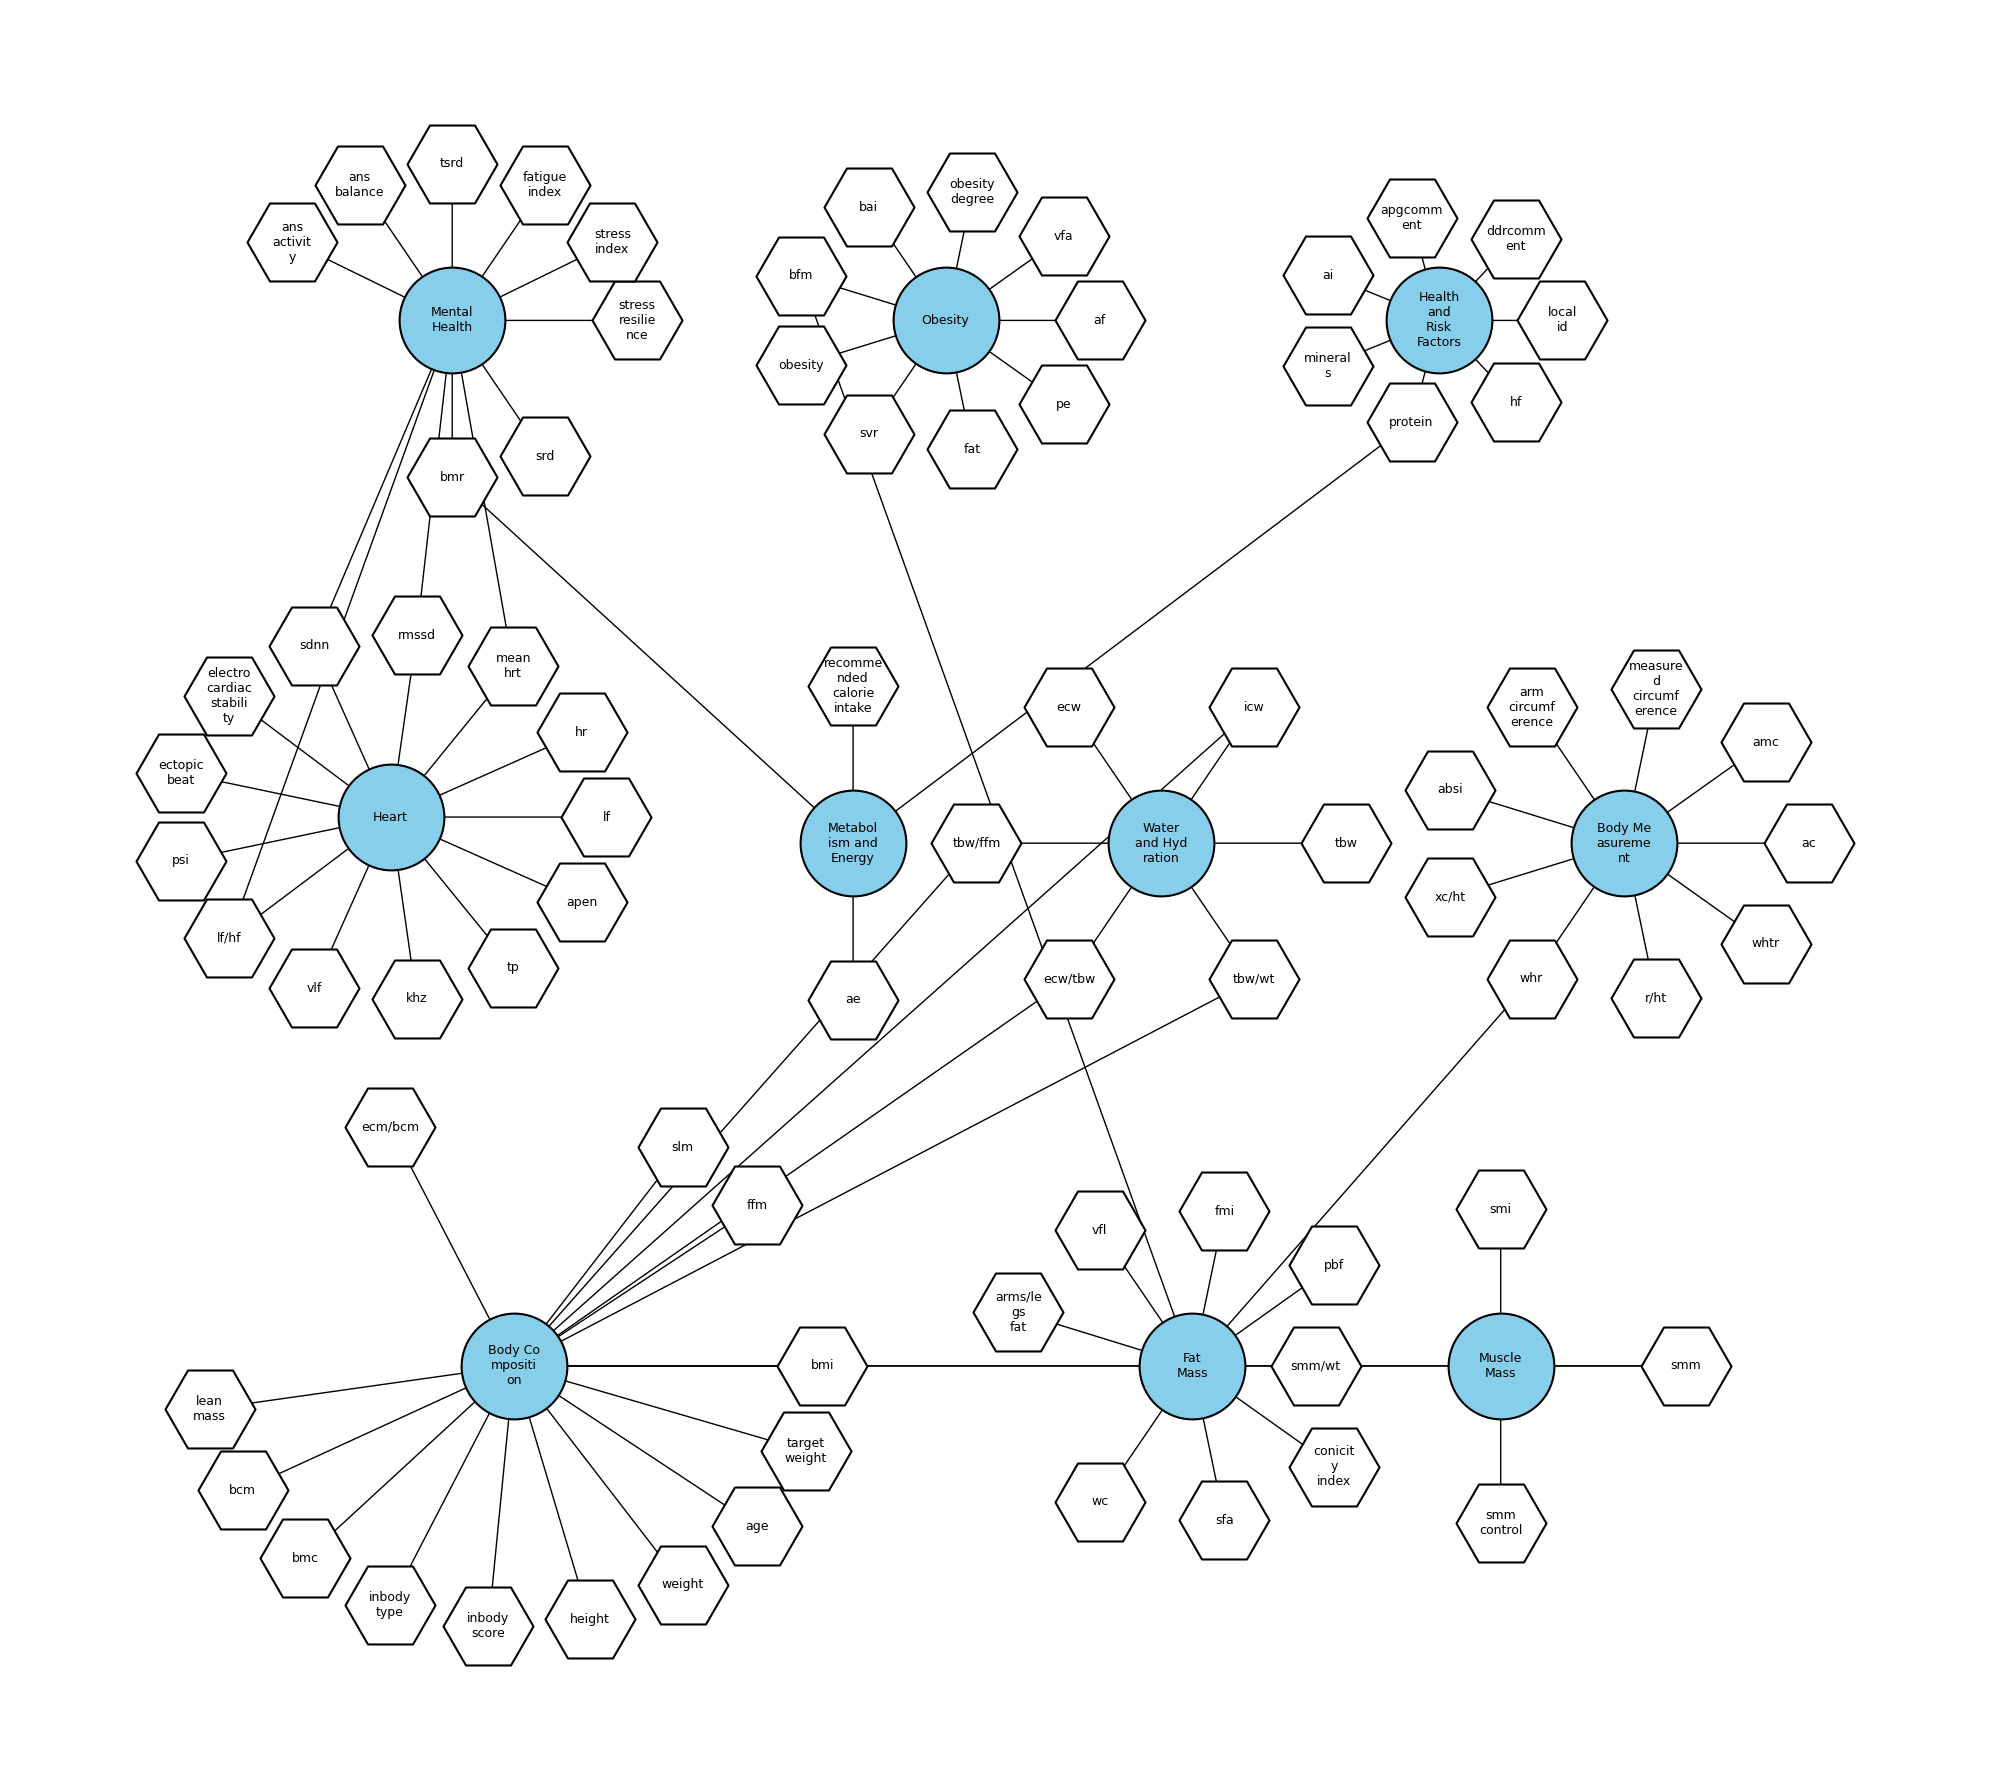

In [ ]:
fixed_pos_risk = {
    'Body Composition': (0.4, 0),
    'Obesity': (1.8, 4),
    'Health and Risk Factors': (3.4, 4),
    'Metabolism and Energy': (1.5, 2),
    'Heart': (0, 2.1),
    'Body Measurement': (4, 2),
    'Mental Health': (0.2, 4),
    'Water and Hydration': (2.5, 2),
    'Fat Mass': (2.6, 0),
    'Muscle Mass': (3.6, 0),
}

radii_risk = [1, 0.6, 0.6, 0.6, 0.6, 0.6, 0.4, 0.5, 0.6, 0.7]

create_graph('risk_mapping', risk_mapping, fixed_pos_risk, radii_risk, 5800, 4200)


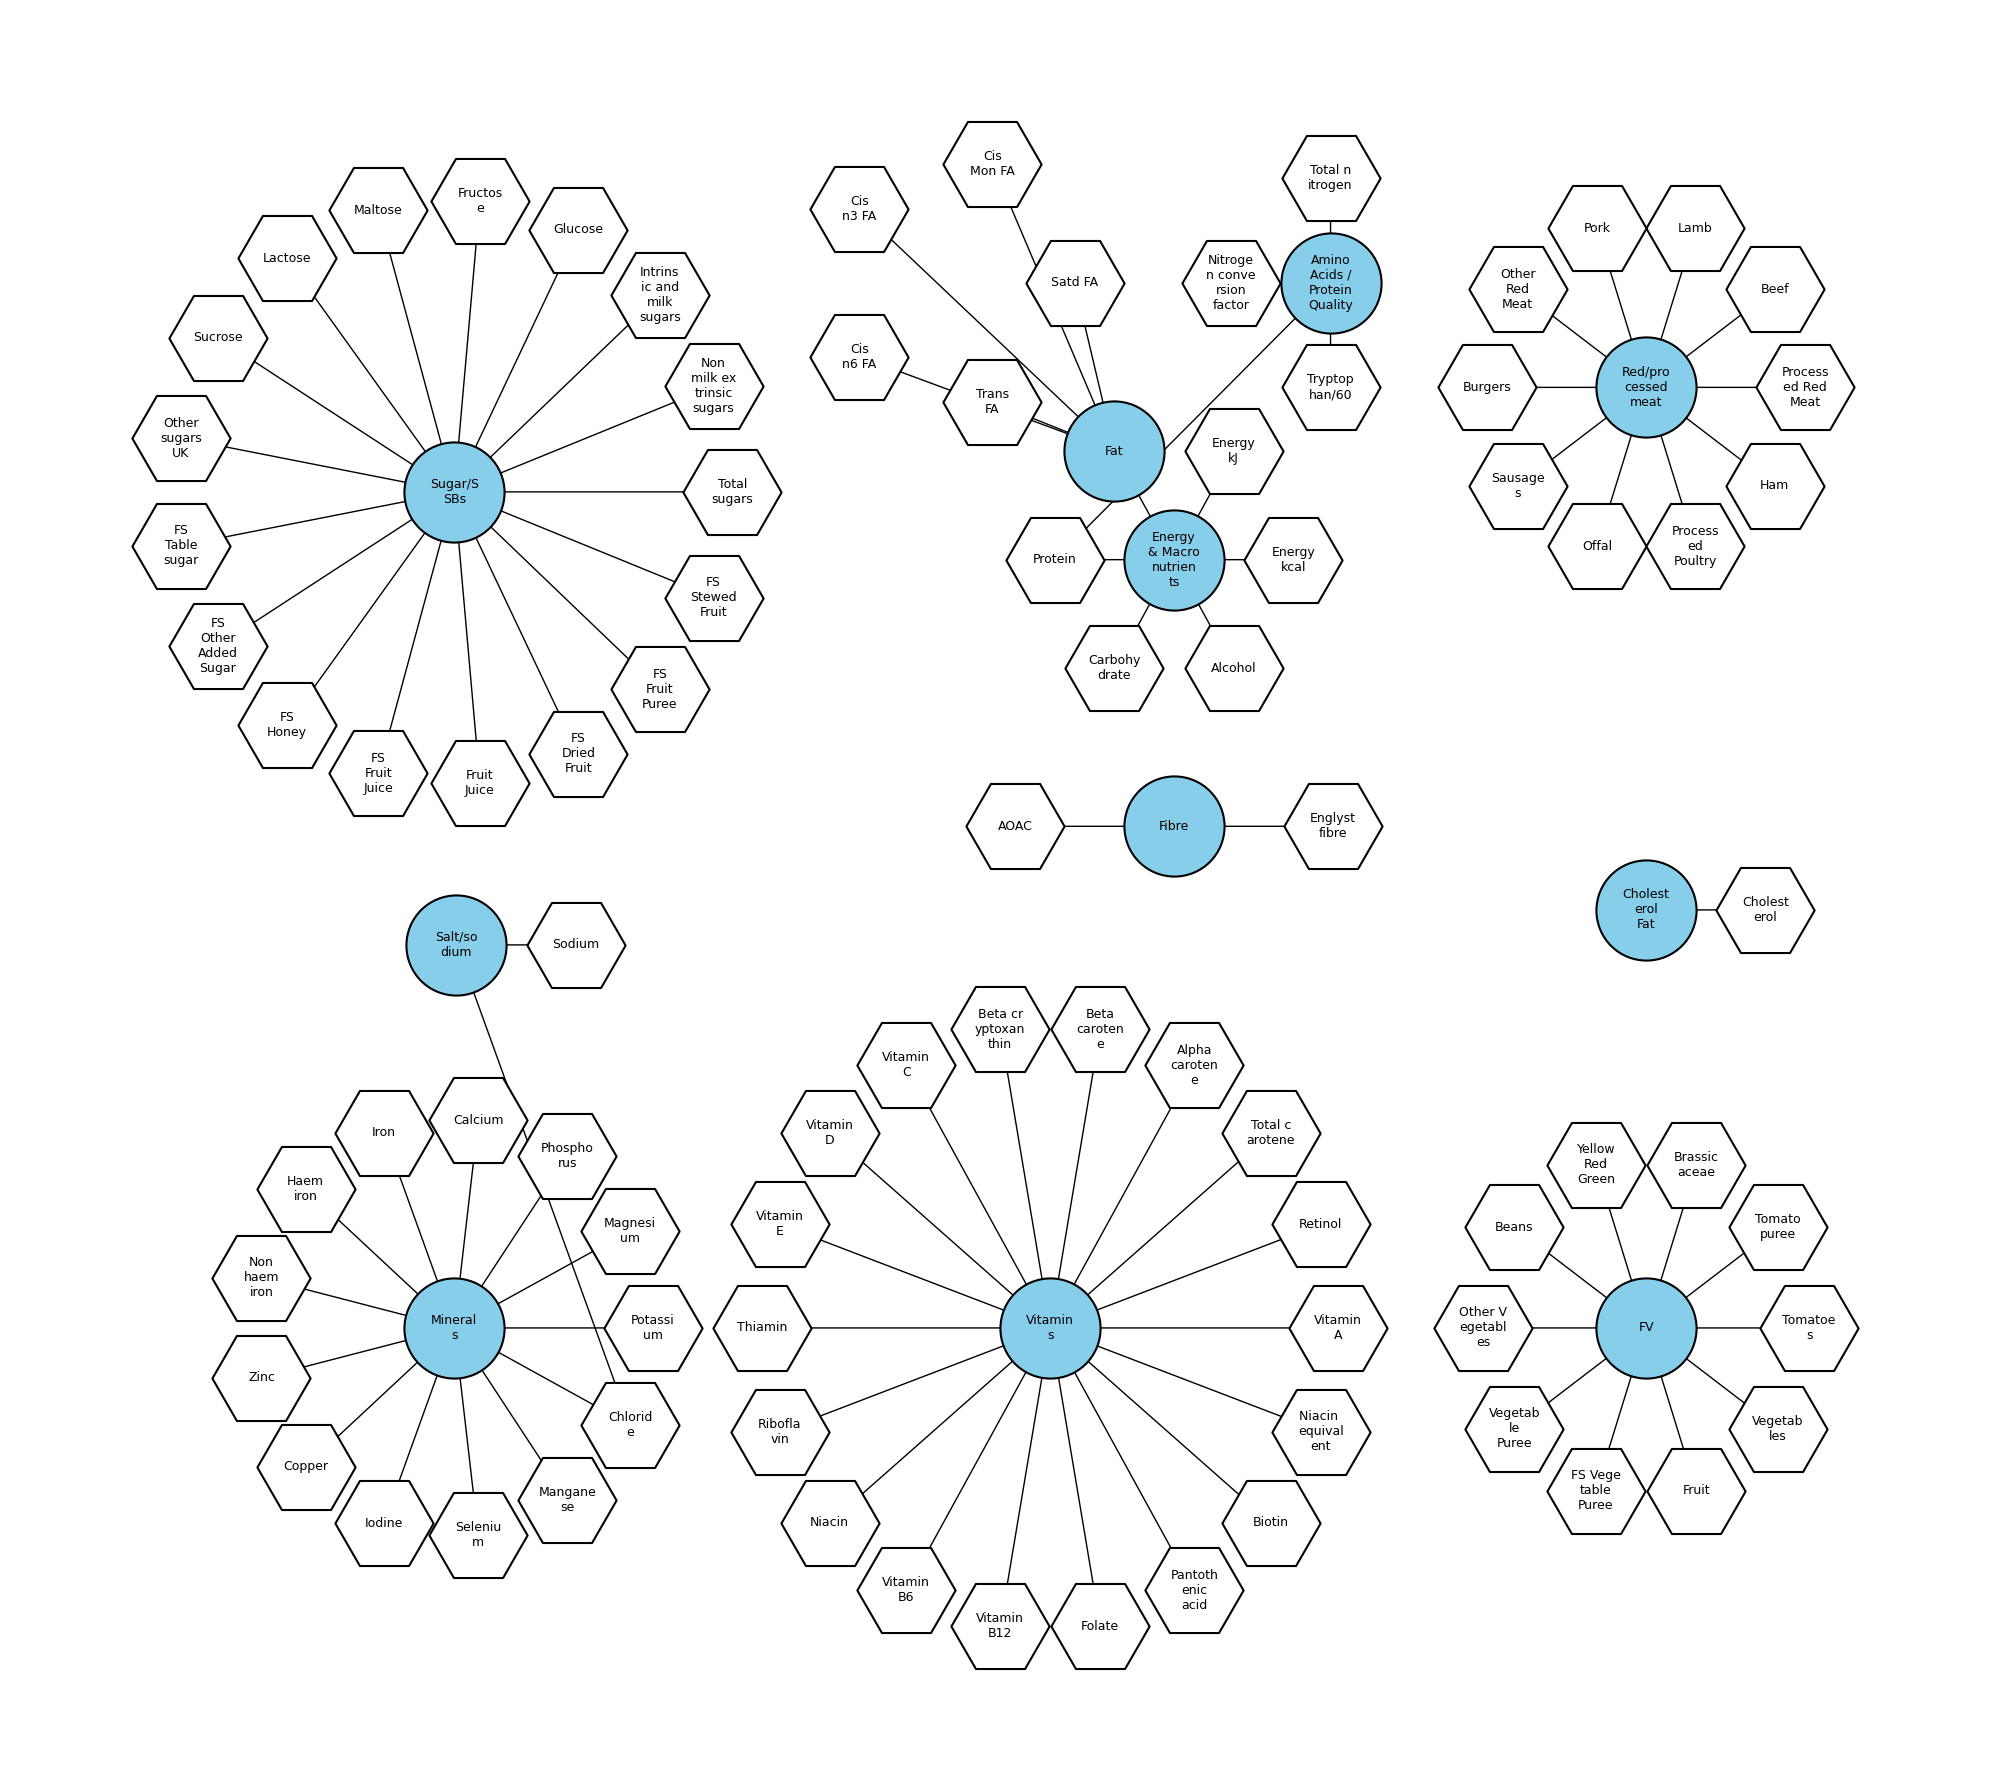

In [ ]:
fixed_pos_nutritional= {
    'Cholesterol Fat': (6, 2),
    'Fat': (2.5235, 5),
    'FV': (6, 0),
    'Sugar/SSBs': (0, 4),
    'Red/processed meat': (6, 4.5),
    'Salt/sodium': (0.0110, 1.8326),
    'Vitamins': (3, 0),
    'Minerals': (0, 0),

    'Energy & Macronutrients': (3.6235, 3.6756),
    'Amino Acids / Protein Quality': (4.4111, 5),
    'Fibre': (3.6235, 2.4)
}
radii_nutritional = [0.6, 0.6, 0.82, 1.4, 0.8, 0.6, 1.45,1,0.5,0.6,0.8,0.6,0.8,0.6,0.8] # Renamed to 'radii'
create_graph('nutritional_mapping', nutritional_mapping, fixed_pos_nutritional, radii_nutritional, 5200, 5000)

## **2.3 Data Process**

### Remove non_numeric

In [55]:
# Remove non_numeric
non_numeric_intake = list(set(intake.select_dtypes(exclude=['number']).columns)- {'User ID', 'patient', 'visit'})
intake = intake.drop(columns=non_numeric_intake, errors='ignore')
intake = intake.dropna(axis=1, how='all')

non_numeric_biosensors = [
    col for col in biosensors.select_dtypes(exclude=['number']).columns
    if col not in ['patient'] and not col.endswith('status') and not col.endswith('risk')
]
biosensors = biosensors.drop(columns=non_numeric_biosensors, errors='ignore')
biosensors = biosensors.dropna(axis=1, how='all')
print(intake.shape, biosensors.shape)

(32001, 110) (449, 393)


### GroupBy Patient

In [58]:
intake_df = intake.groupby('patient').mean(numeric_only=True).reset_index()
print(intake_df.shape)

(155, 108)


## **2.4 Violin Plots**

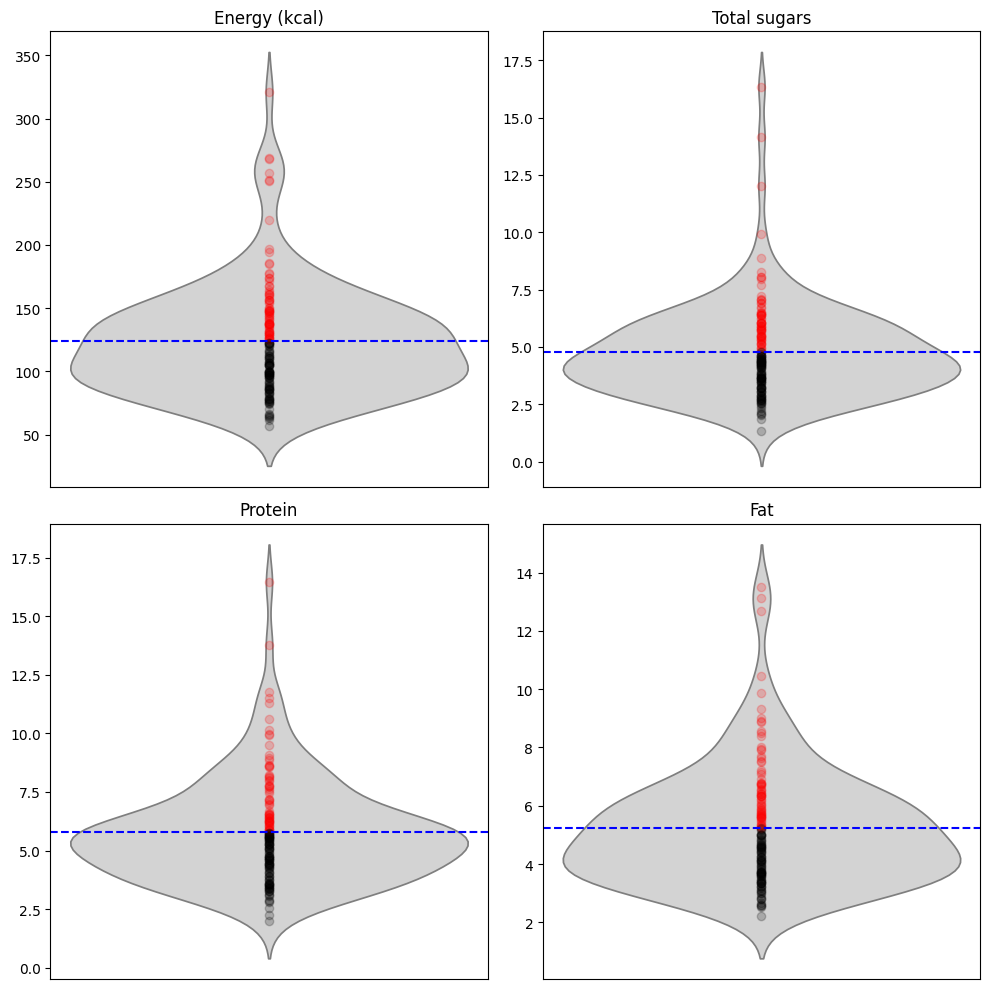

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 创建图形和子图
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

# 要画的列
# columns = ['Water', 'Total nitrogen', 'Nitrogen conversion factor','Protein', 'Carbohydrate', 'Alcohol', 'Starch',
#          'Energy (kcal)', 'Energy (kJ)', 'Fat', 'Total sugars', 'AOAC']
columns = ['Energy (kcal)', 'Total sugars', 'Protein', 'Fat']
# 遍历每个变量，分别绘图
for idx, column_name in enumerate(columns):
    ax = axes[idx]
    mean_value = intake_df[column_name].mean()

    # 小提琴图
    sns.violinplot(y=intake_df[column_name], inner=None, color='lightgray', ax=ax)

    # 添加散点图（标红大于均值的点）
    for val in intake_df[column_name]:
        color = 'red' if val > mean_value else 'black'
        ax.scatter(0, val, color=color, alpha=0.2)

    # 加均值线
    ax.axhline(mean_value, color='blue', linestyle='--')
    ax.set_title(column_name)
    ax.set_ylabel("")
    ax.set_xticks([])

# 移除多余子图（如果有）
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(f'./Results/ExDBN-NutritionalData/CoDiet-Intake24-Biosensor-plots/Nutrition_violin_plot.png')
plt.savefig(f'./Results/ExDBN-NutritionalData/CoDiet-Intake24-Biosensor-plots/Nutrition_violin_plot.pdf', format='pdf')
plt.show()


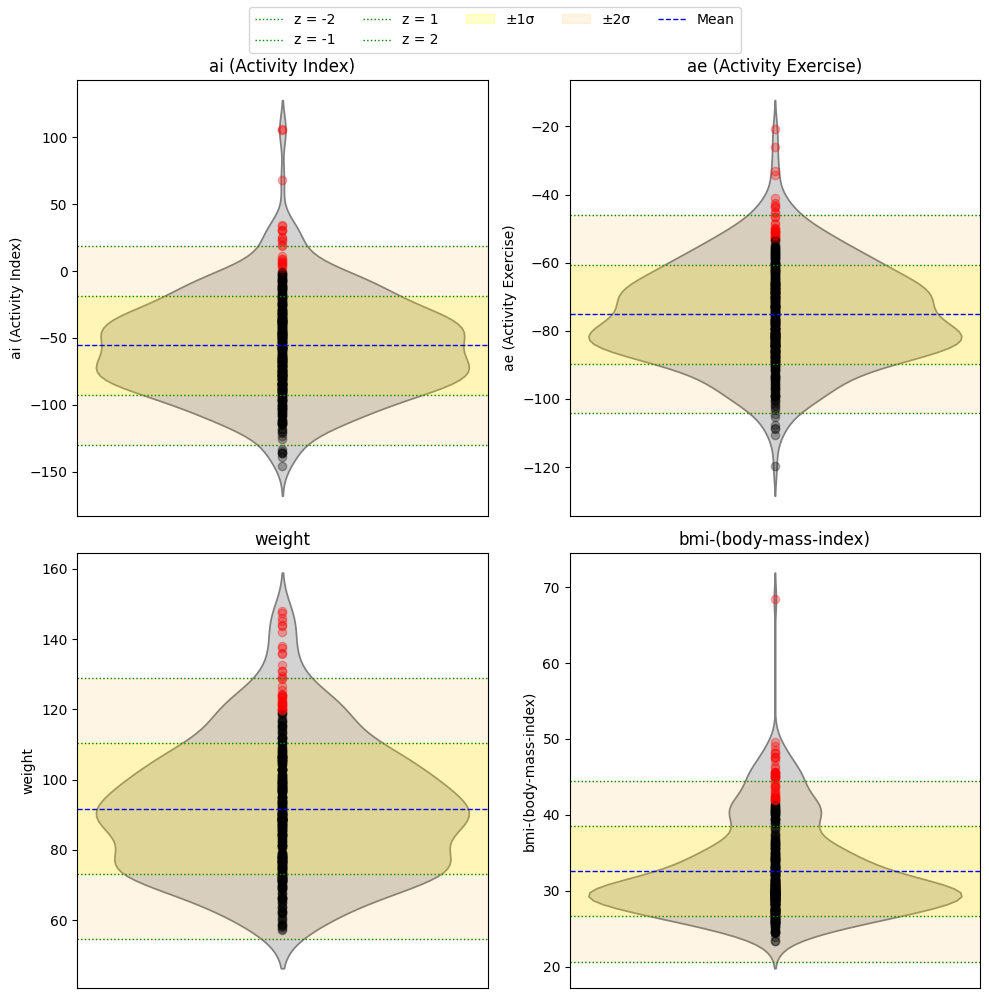

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

columns = ['ai', 'ae', 'weight', 'bmi-(body-mass-index)']
titles = ['ai (Activity Index)', 'ae (Activity Exercise)', 'weight', 'bmi-(body-mass-index)']

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for idx, column in enumerate(columns):
    ax = axes[idx]
    data = biosensors_df[column].dropna()
    mean = data.mean()
    std = data.std()
    z_scores = (data - mean) / std

    # 小提琴图背景
    sns.violinplot(y=data, ax=ax, inner=None, color='lightgray')

    # z-score 阈值线
    for z in [-2, -1, 1, 2]:
        threshold = mean + z * std
        ax.axhline(threshold, color='green', linestyle=':', linewidth=1, label=f"z = {z}")

    # σ 区域
    ax.axhspan(mean - std, mean + std, color='yellow', alpha=0.2, label='±1σ')
    ax.axhspan(mean - 2*std, mean + 2*std, color='orange', alpha=0.1, label='±2σ')

    # 均值线
    ax.axhline(mean, color='blue', linestyle='--', linewidth=1, label='Mean')

    # 散点
    for val, z in zip(data, z_scores):
        color = 'red' if z > 1.5 else 'black'
        ax.scatter(0, val, color=color, alpha=0.3)

    ax.set_title(titles[idx])
    ax.set_ylabel(titles[idx])
    ax.set_xticks([])

# 图例
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.suptitle("Z-Score Visualization (2x2 Subplots)", fontsize=14)
plt.savefig(f'./Results/ExDBN-NutritionalData/CoDiet-Intake24-Biosensor-plots/Risk_violin_plot.png')
plt.savefig(f'./Results/ExDBN-NutritionalData/CoDiet-Intake24-Biosensor-plots/Risk_violin_plot.pdf', format='pdf')
plt.show()


## **2.5 Literature Pathway-Merge**


In [ ]:
def group_data(intake_df, biosensor_df,nutritional_mapping,risk_mapping):
    # Process dietary risk factors
    nutrition_data = []
    for target, cols in nutritional_mapping.items():
        available_cols = [c for c in cols if c in intake_df.columns]
        if available_cols:
            melted = intake_df[['patient'] + available_cols] \
                .melt(id_vars='patient', value_name='Value')

            mean_value = melted['Value'].mean()

            filtered = melted[melted['Value'] > mean_value] \
                .assign(Dietary_Metric_name=target)

        nutrition_data.append(filtered)

    nutrition_df = pd.concat(nutrition_data) if nutrition_data else pd.DataFrame()
    nutrition_df.columns = ['patient', 'Dietary_Metric_name', 'Dietary_Metric_value', 'Dietary Risks']
    nutrition_df = nutrition_df.reset_index(drop=True)
    nutrition_df = nutrition_df[['patient', 'Dietary Risks', 'Dietary_Metric_name', 'Dietary_Metric_value']]
    nutrition_df.to_csv("./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/Patient_nutrition_df.csv", index=False)
    #nutrition_df = nutrition_df[['patient', 'Dietary Risks']].drop_duplicates()
    nutrition_df_patient_count = nutrition_df['patient'].nunique()
    print(f"Patient Number with Dietary Risks Is: {nutrition_df_patient_count},{nutrition_df.shape}")

    # Process intermediate risk factors
    risk_cols = [col for col in biosensor_df.columns if col.endswith('_risk')]
    results = []

    for category, cols in risk_mapping.items():
        available_cols = [c for c in cols if c in biosensor_df.columns]
        for indicator in available_cols:
            # print(indicator)
            risk_col = f"{indicator}_risk"
            # 筛选高风险出现次数>=2的patient
            high_risk_counts = biosensor_df[ biosensor_df[risk_col] == 'high'].groupby('patient').size()
            high_risk_flag = high_risk_counts[high_risk_counts >= 2].index.tolist()

            for patient in high_risk_flag:
                # 取该patient对应indicator在高风险行中的最大值
                val =  biosensor_df[( biosensor_df['patient'] == patient) & ( biosensor_df[risk_col] == 'high')][indicator].max()
                results.append({
                    'patient': patient,
                    'Intermediate Risks': category,
                    'Risk_Metric_name': indicator,
                    'Risk_Metric_value': val
                    })
    risk_summary_df = pd.DataFrame(results)
    risk_summary_df = risk_summary_df.reset_index(drop=True)
    risk_summary_df.to_csv("./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/Patient_risk_df.csv", index=False)
    #risk_summary_df = risk_summary_df[['patient', 'Intermediate Risks']].drop_duplicates()
    risk_df_patient_count = risk_summary_df['patient'].nunique()
    print(f"Patient Number with Intermediate Risks Is: {risk_df_patient_count},{risk_summary_df.shape}")

    merged_df = pd.merge(nutrition_df, risk_summary_df, on='patient', how='inner')
    merged_df.to_csv("./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/Patient_merged_df.csv", index=False)
    #print(merged_df.head())
    summary_patient_count = merged_df['patient'].nunique()
    print(f"Patient Number Is: {summary_patient_count},{merged_df.shape}")

    summary_by_metric = merged_df.groupby(['Dietary_Metric_name', 'Risk_Metric_name']).size().reset_index(name='Patient_Count')
    #summary_by_category1 = merged_df.groupby(['Dietary_Metric_name', 'Risk_Metric_name', 'Dietary Risks', 'Intermediate Risks']).size().reset_index(name='Patient_Count')
    summary_by_category = merged_df.groupby(['Dietary Risks', 'Intermediate Risks']).size().reset_index(name='Patient_Count')

    return merged_df, nutrition_df, risk_summary_df, summary_by_metric, summary_by_category

In [ ]:
merged_df, nutrition_df, risk_df, summary_by_metric, summary_by_category = group_data(intake_df, biosensors_df,nutritional_mapping,risk_mapping)
# total = summary_df['Patient_Count'].sum()
# nutrition_df
# risk_df
# summary_by_category

Patient Number with Dietary Risks Is: 155,(3862, 4)
Patient Number with Intermediate Risks Is: 150,(9324, 4)
Patient Number Is: 147,(230646, 7)


In [ ]:
merged_df

,patient,Dietary Risks,Dietary_Metric_name,Dietary_Metric_value,Intermediate Risks,Risk_Metric_name,Risk_Metric_value
0,CD-003,Cholesterol Fat,Cholesterol,22.755862,Body Measurement,absi(a-body-shaped-index),0.086
1,CD-003,Cholesterol Fat,Cholesterol,22.755862,Body Measurement,ac-(arm-circumference),43.100
2,CD-003,Cholesterol Fat,Cholesterol,22.755862,Body Measurement,amc-(arm-muscle-circumference),33.100
3,CD-003,Cholesterol Fat,Cholesterol,22.755862,Body Measurement,measured-circumference-of-abdomen,127.700
4,CD-003,Cholesterol Fat,Cholesterol,22.755862,Body Measurement,measured-circumference-of-chest,114.000
...,...,...,...,...,...,...,...
230641,CD-404,Fibre,AOAC,1.133052,Water and Hydration,tbw-of-left-arm,2.470
230642,CD-404,Fibre,AOAC,1.133052,Water and Hydration,tbw-of-left-leg,5.430
230643,CD-404,Fibre,AOAC,1.133052,Water and Hydration,tbw-of-right-arm,2.440
230644,CD-404,Fibre,AOAC,1.133052,Water and Hydration,tbw-of-trunk,19.900


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


* Normalize_Literature

In [ ]:
#正则化-保证最后绘图应每类的个数保持在统一比较起点
plot_data_literature = summary_by_category.merge(category_counts_inter, on='Intermediate Risks', how='left')
plot_data_literature = plot_data_literature.merge(category_counts_diet, on='Dietary Risks', how='left')
plot_data_literature['Normalized_Patient'] = plot_data_literature['Patient_Count'] / plot_data_literature['Intermediate_Risk_Count']/ plot_data_literature['Dietary_Risk_Count']
plot_data_literature = plot_data_literature[['Dietary Risks', 'Intermediate Risks','Patient_Count','Normalized_Patient']]
plot_data_literature.to_csv("./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/plot_data_literature.csv", index=False)
plot_data_literature


,Dietary Risks,Intermediate Risks,Patient_Count,Normalized_Patient
0,Amino Acids / Protein Quality,Body Composition,4753,33.006944
1,Amino Acids / Protein Quality,Body Measurement,2237,37.283333
2,Amino Acids / Protein Quality,Fat Mass,2430,35.735294
3,Amino Acids / Protein Quality,Health and Risk Factors,926,38.583333
4,Amino Acids / Protein Quality,Heart,1365,28.437500
...,...,...,...,...
105,Vitamins,Mental Health,3121,21.673611
106,Vitamins,Metabolism and Energy,1628,22.611111
107,Vitamins,Muscle Mass,88,4.888889
108,Vitamins,Obesity,3044,21.138889


## **2.6 Adjacency Matrix**

In [ ]:
import pandas as pd

adjacency_matrix = summary_by_metric.pivot_table(index='Dietary_Metric_name', columns='Risk_Metric_name', values='Patient_Count', fill_value=0)
adjacency_matrix.to_csv("./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/weight_adj_matrix.csv", encoding='utf-8')
print(adjacency_matrix)

mean_val = adjacency_matrix.values.mean()
std_val = adjacency_matrix.values.std()
zscore_normalized = (adjacency_matrix - mean_val) / std_val
# print(zscore_normalized)
# 保存到CSV文件
zscore_normalized.to_csv("./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/normalized_weight_matrix.csv", encoding='utf-8')


Risk_Metric_name            absi(a-body-shaped-index)  ac-(arm-circumference)  \
Dietary_Metric_name                                                             
AOAC                                             77.0                    32.0   
Alpha-carotene                                   49.0                    16.0   
Beans                                            10.0                     4.0   
Beef                                             80.0                    36.0   
Beta cryptoxanthin                                1.0                     1.0   
Beta-carotene                                   131.0                    53.0   
Brassicaceae                                      6.0                     2.0   
Burgers                                          29.0                    15.0   
Calcium                                          91.0                    41.0   
Chloride                                        221.0                    91.0   
Cholesterol                 

* Old-adj-matrix

In [ ]:
import pandas as pd

intake_df = pd.read_csv('./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/intake_df.csv', sep=';')
biosensors_df = pd.read_csv('./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/biosensors_df.csv', sep=';')
bio_col_matching = pd.read_csv('./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/bio_col_matching.csv')

print(intake_df.columns, intake_df.shape)
print(biosensors_df.columns, biosensors_df.shape)
#print(bio_col_matching)#.columns, bio_col_matching.shape)

Index(['patient', 'Meal ID', 'Food ID', 'Nutrient table code',
       'Food group code', 'Ready meal', 'Serving size (g/ml)',
       'Leftovers (g/ml)', 'Portion size (g/ml)', 'Reasonable amount',
       ...
       'Poultry', 'Processed Poultry', 'Game Birds', 'White Fish', 'Oily Fish',
       'Canned Tuna', 'Shellfish', 'Cottage Cheese', 'Cheddar Cheese',
       'Other Cheese'],
      dtype='object', length=108) (155, 108)
Index(['patient', 'ai', 'ai-status', 'ae', 'ae-status', 'pe', 'pe-status',
       'hr', 'hr-status', 'ans-activity',
       ...
       'tsrd-whole-body_risk', 'vfa-abdomen_risk', 'vfl-abdomen_risk',
       'vlf-heart_risk', 'wc -waist_risk', 'weight-control-whole-body_risk',
       'weight-whole-body_risk', 'whr-waist_risk', 'whtr-waist_risk',
       'xc/ht-whole-body_risk'],
      dtype='object', length=391) (449, 391)


In [ ]:
import pandas as pd
import numpy as np

def group_matrix(intake_df, biosensor_df):
    # --- Nutrition data processing ---
    nutrition_cols = [col for col in intake_df.columns if col != 'patient']
    nutrition_data = []
    for col in nutrition_cols:
        melted = intake_df[['patient', col]].copy()
        melted = melted.rename(columns={col: 'Value'})
        mean_value = melted['Value'].mean()
        filtered = melted[melted['Value'] > mean_value].copy()
        if not filtered.empty:
            filtered['Dietary Risks'] = col
            nutrition_data.append(filtered)

    nutrition_df = pd.concat(nutrition_data) if nutrition_data else pd.DataFrame(columns=['patient', 'Dietary Risks'])

    # --- Risk factor processing ---
    risk_cols = [col for col in biosensor_df.columns if col.endswith('_risk')]
    high_threshold = 2
    risk_data = []

    if risk_cols:
        def count_high_risks(group):
            high_count = (group[risk_cols] == 'high').sum(axis=1)
            return (high_count >= high_threshold).any()

        high_risk_patients = biosensor_df.groupby('patient').filter(count_high_risks)

        if not high_risk_patients.empty:
            for col in risk_cols:
                temp = high_risk_patients[['patient', col]].copy()
                temp['Risk_Factor'] = col.replace('_risk', '')
                risk_data.append(temp)

    risk_df = pd.concat(risk_data) if risk_data else pd.DataFrame(columns=['patient', 'Risk_Factor'])

    # --- Merge and summarize ---
    if not nutrition_df.empty and not risk_df.empty:
        merged_df = pd.merge(nutrition_df[['patient', 'Dietary Risks']],
                             risk_df[['patient', 'Risk_Factor']],
                             on='patient', how='inner')
        summary_df = merged_df.groupby(['Dietary Risks', 'Risk_Factor']).size().reset_index(name='Patient_Count')
    else:
        summary_df = pd.DataFrame(columns=['Dietary Risks', 'Risk_Factor', 'Patient_Count'])

    return summary_df

def to_adjacency_matrix(summary_df):
    # 获取所有唯一的节点（营养+风险）
    nodes = pd.unique(summary_df[['Dietary Risks', 'Risk_Factor']].values.ravel())
    nodes.sort()  # 保证顺序一致（可选）

    # 创建方形空矩阵
    adj_matrix = pd.DataFrame(0, index=nodes, columns=nodes)

    # 填充矩阵：由于是无向图，只填 [i,j] 和 [j,i]
    for _, row in summary_df.iterrows():
        n_target = row['Dietary Risks']
        r_factor = row['Risk_Factor']
        count = row['Patient_Count']
        adj_matrix.loc[n_target, r_factor] = count
        #adj_matrix.loc[r_factor, n_target] = count

    normalized = adj_matrix.copy().astype(float)

    # 获取非零最大值
    max_val = normalized[normalized != 0].max().max()

    # 避免除以 0
    if max_val > 0:
        normalized = normalized.map(lambda x: x / max_val if x != 0 else 0)

    np.fill_diagonal(adj_matrix.values, 0)

    return normalized


In [ ]:
adjacency_gt = group_matrix(intake_df, biosensors_df)
adj_matrix_Literature_scaled = to_adjacency_matrix(adjacency_gt)
print(adj_matrix_Literature_scaled)
adj_matrix_Literature_scaled.to_csv("./Results/ExDBN-NutritionalData/adjacency_matrix_groundtruth.csv", index=False, sep=';')

                           AOAC  Alcohol  Alpha-carotene  Beans  Beef  \
AOAC                          0        0               0      0     0   
Alcohol                       0        0               0      0     0   
Alpha-carotene                0        0               0      0     0   
Beans                         0        0               0      0     0   
Beef                          0        0               0      0     0   
...                         ...      ...             ...    ...   ...   
weight-control-whole-body     0        0               0      0     0   
weight-whole-body             0        0               0      0     0   
whr-waist                     0        0               0      0     0   
whtr-waist                    0        0               0      0     0   
xc/ht-whole-body              0        0               0      0     0   

                           Beta cryptoxanthin  Beta-carotene  Biotin  \
AOAC                                        0      

# ***Casuality_ExDBN***

## **3.1 Merge**

In [ ]:
intake_DBN = intake.groupby(['User ID', 'patient', 'visit']).mean(numeric_only=True).reset_index()
column_name = bio_col_matching['metric_name']
biosensors_DBN = biosensors_risk[['User ID', 'patient', 'visit'] + column_name.tolist()]

DBN_test_data = pd.merge(intake_DBN, biosensors_DBN, on=['User ID','patient', 'visit'], how='inner', suffixes=('_intake', '_biosensors'))
DBN_test_data.to_csv('./Results/ExDBN-NutritionalData/DBN_test_data.csv', sep=';', index=False)

##  **3.2 Run in ExDBN**

See [Test Dynotear-nutrition](https://colab.research.google.com/drive/1tOYcTU1dOHqZzGvPf7osDPKVmGzZP6ro#scrollTo=LEe-pU4eBlT7)



## **3.3 Read edges with lags**

In [ ]:
edges = pd.read_csv('./Results/ExDBN-NutritionalData/ExDBN_edges.csv', sep=';')
edges

(2563872, 4)


,patient,source,target,weight
0,CD-003,Water_lag0,Total nitrogen_lag0,1.644200e-08
1,CD-003,Water_lag0,Protein_lag0,5.180703e-06
2,CD-003,Water_lag0,Fat_lag0,1.055806e-05
3,CD-003,Water_lag0,Energy (kcal)_lag0,6.844916e-04
4,CD-003,Water_lag0,Energy (kJ)_lag0,5.206048e-04
...,...,...,...,...
2563867,CD-379,xc/ht_lag0,srd_lag0,3.103667e-09
2563868,CD-379,xc/ht_lag1,Phosphorus_lag0,-1.177613e-09
2563869,CD-379,xc/ht_lag1,ans-balance_lag0,6.767463e-09
2563870,CD-379,xc/ht_lag1,ecw-of-left-leg_lag0,2.260899e-09


## **3.4 Predicted Pathway**

* Normalize

In [ ]:
# Nutritional_Target	Risk_Factor User_Count
edges['source'] = edges['source'].apply(lambda x: x.split('_')[0])  # 提取'_'前的部分
edges['target'] = edges['target'].apply(lambda x: x.split('_')[0])
# 示例边结构：edge = {'source': 'A', 'target': 'B', 'weight': -0.3}

def normalize_edges(edges):
    for edge in edges:
        if edge['weight'] < 0:
            edge['source'], edge['target'] = edge['target'], edge['source']
            edge['weight'] = abs(edge['weight'])
    return edges

def build_reverse_mapping(mapping):
    reverse = {}
    for category, items in mapping.items():
        for item in items:
            reverse[item] = category
    return reverse

nutrient_reverse_map = build_reverse_mapping(nutritional_mapping)
risk_reverse_map = build_reverse_mapping(risk_mapping)

# 分类变量名
def classify_variable(var_name):
    if var_name in nutrient_reverse_map:
        return 'Nutrient', nutrient_reverse_map[var_name]
    elif var_name in risk_reverse_map:
        return 'Risk', risk_reverse_map[var_name]
    return 'Other', None

def process_edges(edges):
    processed = []
    for edge in edges:
        # 处理权重为负数
        if edge['weight'] < 0:
            edge['source'], edge['target'] = edge['target'], edge['source']
            edge['weight'] = abs(edge['weight'])

        source_type, source_cat = classify_variable(edge['source'])
        target_type, target_cat = classify_variable(edge['target'])

        edge['source_type'] = source_type
        edge['Nutritional_Target'] = source_cat
        edge['target_type'] = target_type
        edge['Risk_Factor'] = target_cat
        processed.append(edge)
    return processed

result = process_edges(edges.to_dict('records'))
df = pd.DataFrame(result)
df = df[df['weight'] >= 1e-6]
df['weight'] = 1
summary_df = df.groupby(['Nutritional_Target', 'Risk_Factor'], as_index=False)['weight'].sum()
summary_df.rename(columns={'weight': 'User_Count',
                           'Nutritional_Target': 'Dietary Risks',
                           'Risk_Factor': 'Intermediate Risks'
                           }, inplace=True)
summary_df = summary_df[~summary_df['Dietary Risks'].isin(risk_mapping.keys())]
summary_df = summary_df[~summary_df['Intermediate Risks'].isin(nutritional_mapping.keys())]
summary_df_ExDBN=pd.DataFrame(summary_df.reset_index(drop=True))

#正则化-保证最后绘图应每类的个数保持在统一比较起点
plot_data_ExDBN = summary_df_ExDBN.merge(category_counts_inter, on='Intermediate Risks', how='left')
plot_data_ExDBN = plot_data_ExDBN.merge(category_counts_diet, on='Dietary Risks', how='left')
plot_data_ExDBN['Normalized_User'] = plot_data_ExDBN['User_Count'] / plot_data_ExDBN['Intermediate_Risk_Count']/ plot_data_ExDBN['Dietary_Risk_Count']
plot_data_ExDBN = plot_data_ExDBN[['Dietary Risks', 'Intermediate Risks','User_Count','Normalized_User']]
plot_data_ExDBN.to_csv('./Results/ExDBN-NutritionalData/plot_data_ExDBN.csv', index=False)
plot_data_ExDBN

,Dietary Risks,Intermediate Risks,User_Count,Normalized_User
0,Amino Acids / Protein Quality,Body Composition,85,0.590278
1,Amino Acids / Protein Quality,Body Measurement,20,0.333333
2,Amino Acids / Protein Quality,Health and Risk Factors,3,0.125000
3,Amino Acids / Protein Quality,Heart,3,0.062500
4,Amino Acids / Protein Quality,Metabolism and Energy,458,28.625000
...,...,...,...,...
76,Vitamins,Mental Health,781,5.423611
77,Vitamins,Metabolism and Energy,10297,143.013889
78,Vitamins,Muscle Mass,8,0.444444
79,Vitamins,Obesity,664,4.611111


# Plots
* Sankey, Barplots, Heatmap

### **4.1 Read Data**

In [14]:
import pandas as pd

summary_df_ExDBN = pd.read_csv('./Results/ExDBN-NutritionalData/plot_data_ExDBN.csv')
summary_df_Literature = pd.read_csv("./Results/ExDBN-NutritionalData/CoDiet-Literature-Results/plot_data_literature.csv")

In [15]:
summary_df_ExDBN

,Dietary Risks,Intermediate Risks,User_Count,Normalized_User
0,Amino Acids / Protein Quality,Body Composition,85,0.590278
1,Amino Acids / Protein Quality,Body Measurement,20,0.333333
2,Amino Acids / Protein Quality,Health and Risk Factors,3,0.125000
3,Amino Acids / Protein Quality,Heart,3,0.062500
4,Amino Acids / Protein Quality,Metabolism and Energy,458,28.625000
...,...,...,...,...
76,Vitamins,Mental Health,781,5.423611
77,Vitamins,Metabolism and Energy,10297,143.013889
78,Vitamins,Muscle Mass,8,0.444444
79,Vitamins,Obesity,664,4.611111


## **4.2 Summary**

In [16]:
# ======================
# Step 1. Count category number
# ======================
def count_patient(summary_df):
    # 兼容两种计数字段
    if 'User_Count' in summary_df.columns:
        summary_df = summary_df.rename(columns={'User_Count': 'Count'})
    elif 'Patient_Count' in summary_df.columns:
        summary_df = summary_df.rename(columns={'Patient_Count': 'Count'})
    elif 'Normalized_User' in summary_df.columns:
        summary_df = summary_df.rename(columns={'Normalized_User': 'Count'})
    elif 'Normalized_Patient' in summary_df.columns:
        summary_df = summary_df.rename(columns={'Normalized_Patient': 'Count'})
    else:
        raise ValueError("未找到计数字段，请检查列名。")

    # 按类别统计
    nutritional_sum = (
        summary_df.groupby('Dietary Risks')['Count']
        .sum()
        .reset_index()
        .rename(columns={'Dietary Risks': 'Label'})
        .sort_values('Count', ascending=True)
        .reset_index(drop=True)
    )

    risk_sum = (
        summary_df.groupby('Intermediate Risks')['Count']
        .sum()
        .reset_index()
        .rename(columns={'Intermediate Risks': 'Label'})
        .sort_values('Count', ascending=True)
        .reset_index(drop=True)
    )

    return nutritional_sum, risk_sum


# 分别统计
nutritional_sum_ExDBN, risk_sum_ExDBN = count_patient(summary_df_ExDBN)
nutritional_sum_groundtruth, risk_sum_groundtruth = count_patient(summary_df_Literature)


# ======================
# Step 2. Normalize
# ======================
def normalize(df):
    df['Normalized'] = df['Count'] / df['Count'].sum()
    return df

nutritional_sum_ExDBN = normalize(nutritional_sum_ExDBN)
risk_sum_ExDBN = normalize(risk_sum_ExDBN)
nutritional_sum_groundtruth = normalize(nutritional_sum_groundtruth)
risk_sum_groundtruth = normalize(risk_sum_groundtruth)


# ======================
# Step 3. Outer merge nutritional & risk tables
# ======================
nutritional_merged_ = pd.merge(
    nutritional_sum_groundtruth[['Label', 'Normalized']],
    nutritional_sum_ExDBN[['Label', 'Normalized']],
    on='Label',
    how='outer',
    suffixes=('_groundtruth', '_ExDBN')
).fillna(0)

risk_merged_ = pd.merge(
    risk_sum_groundtruth[['Label', 'Normalized']],
    risk_sum_ExDBN[['Label', 'Normalized']],
    on='Label',
    how='outer',
    suffixes=('_groundtruth', '_ExDBN')
).fillna(0)


# ======================
# Step 4. Rank Labels
# ======================
# 按 ExDBN 排序
nutritional_merged_ExDBN = nutritional_merged_.sort_values('Normalized_ExDBN', ascending=False).reset_index(drop=True)
risk_merged_ExDBN = risk_merged_.sort_values('Normalized_ExDBN', ascending=False).reset_index(drop=True)
ExDBN_nutritional_order = nutritional_merged_ExDBN.Label.tolist()
ExDBN_risk_order = risk_merged_ExDBN.Label.tolist()

# 删除 "Stomach"（如存在）
ExDBN_risk_order = [label for label in ExDBN_risk_order if label != 'Stomach']

# 按 Literature 排序
nutritional_merged_groundtruth = nutritional_merged_.sort_values('Normalized_groundtruth', ascending=False).reset_index(drop=True)
risk_merged_groundtruth = risk_merged_.sort_values('Normalized_groundtruth', ascending=False).reset_index(drop=True)
Literature_nutritional_order = nutritional_merged_groundtruth.Label.tolist()
Literature_risk_order = [label for label in risk_merged_groundtruth.Label.tolist() if label != 'Stomach']


# ======================
# Step 5. Set ordered categorical levels
# ======================
# --- ExDBN ---
summary_df_ExDBN['Dietary Risks'] = pd.Categorical(
    summary_df_ExDBN['Dietary Risks'],
    categories=ExDBN_nutritional_order,
    ordered=True
)
summary_df_ExDBN['Intermediate Risks'] = pd.Categorical(
    summary_df_ExDBN['Intermediate Risks'],
    categories=ExDBN_risk_order,
    ordered=True
)
summary_df_ExDBN_sorted = summary_df_ExDBN.sort_values(['Dietary Risks', 'Intermediate Risks']).reset_index(drop=True)

# --- Literature ---
summary_df_Literature['Dietary Risks'] = pd.Categorical(
    summary_df_Literature['Dietary Risks'],
    categories=Literature_nutritional_order,
    ordered=True
)
summary_df_Literature['Intermediate Risks'] = pd.Categorical(
    summary_df_Literature['Intermediate Risks'],
    categories=Literature_risk_order,
    ordered=True
)
summary_df_Literature_sorted = summary_df_Literature.sort_values(['Dietary Risks', 'Intermediate Risks']).reset_index(drop=True)


# ======================
# Step 6. 输出结果检查
# ======================
print("✅ ExDBN nutritional order:", ExDBN_nutritional_order)
print("✅ ExDBN risk order:", ExDBN_risk_order)
print("✅ Literature nutritional order:", Literature_nutritional_order)
print("✅ Literature risk order:", Literature_risk_order)


✅ ExDBN nutritional order: ['Energy & Macronutrients', 'Minerals', 'Vitamins', 'Sugar/SSBs', 'Salt/sodium', 'Fat', 'FV', 'Red/processed meat', 'Fibre', 'Amino Acids / Protein Quality', 'Cholesterol Fat', 'High In Sodium', 'High In Red Meat', 'High In Processed Meat', 'High In Sugar-Sweetened Beverages', 'High In Trans Fatty Acids', 'Low In Calcium', 'Low In (Omega-6)Polyunsaturated Fatty Acids', 'Low In Nuts And Seeds', 'Low In Milk', 'Low In Legumes', 'Low In Fruits', 'Low In Fiber', 'Low In Whole Grains', 'Low In Seafood Omega-3 Fatty Acids', 'Low In Vegetables']
✅ ExDBN risk order: ['Metabolism and Energy', 'Body Composition', 'Body Measurement', 'Fat Mass', 'Heart', 'Mental Health', 'Obesity', 'Water and Hydration', 'Health and Risk Factors', 'Muscle Mass', 'Chronic kidney disease', 'Aortic aneurysm', 'High systolic blood pressure', 'High fasting plasma glucose', 'High LDL cholesterol', 'Diabetes mellitus type 2', 'Drug-susceptible tuberculosis', 'Lower extremity peripheral arteria

## **4.3 Sankey diagram-Pathway**

[Alluvial Plot](https://plotly.com/graphing-libraries/)

In [17]:
pip install pandas openpyxl plotly

In [18]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

def generate_sankey_diagram(pathway_counts, value_col):
    # 只取 Nutritional_Target 和 Risk_Factor
    all_nodes = (
        pathway_counts['Dietary Risks'].unique().tolist() +
        pathway_counts['Intermediate Risks'].unique().tolist()
    )
    #all_nodes = ExDBN_nutritional_order+ExDBN_risk_order
    #all_nodes = Literature_nutritional_order+Literature_risk_order

    # 创建节点索引
    node_indices = {node: idx for idx, node in enumerate(all_nodes)}

    # 创建 source-target-value 列表
    sources = []
    targets = []
    values = []
    labels = all_nodes.copy()

    # 只连 Nutritional Target -> Risk Factor
    for _, row in pathway_counts.iterrows():
        sources.append(node_indices[row['Dietary Risks']])
        targets.append(node_indices[row['Intermediate Risks']])
        values.append(row[value_col])

    # 节点上色
    nutritional_targets = pathway_counts['Dietary Risks'].unique().tolist()
    intermediate_factors = pathway_counts['Intermediate Risks'].unique().tolist()

    node_colors = []
    for node in all_nodes:
        if node in nutritional_targets:
            node_colors.append('#1F77B4')  # 蓝色 Nutritional Targets
        else:
            node_colors.append('#ECECEC')  # 红色 Risk Factors

    risks = pathway_counts['Intermediate Risks'].unique().tolist()

    risk_colors = {
        'Body Composition': '#84BEDB',       # #84BEDB
        'Muscle Mass': '#A8B8D9',             # #A8B8D9
        'Water and Hydration': '#B3E6E9',     # #B3E6E9
        'Fat Mass': '#6D7197',                # #6D7197
        'Metabolism and Energy': '#628EB2',   # #628EB2
        'Body Measurement': '#E7B4D3',        # #E7B4D3
        'Health and Risk Factors': '#EFD2C9', # #EFD2C9
        'Obesity': '#B7E1F5',                 # #B7E1F5
        'Diabetes': '#FFF7D9',                # #FFF7D9
        'Mental Health': '#BAC4D2',           # #BAC4D2
        'Heart': '#B4D0DE',                   # #B4D0DE
        'Liver': '#F6C5B5',                   # #F6C5B5
        'Spleen': '#B2CEF4',                  # #B2CEF4
        'Stomach': '#FEE8C6',                 # #FEE8C6
        'Kidney': '#1F77B4',                  # #1F77B4
    }


    link_colors = []
    for target in targets:
        if all_nodes[target] in risks:
            link_colors.append(risk_colors.get(all_nodes[target], 'rgba(200,200,200,0.5)'))
        else:
            link_colors.append('rgba(200,200,200,0.5)')

    nutritional_target_y = np.linspace(0.1, 0.9, len(nutritional_targets))  # 为 Nutritional Targets 设置紧凑的 y 坐标
    risk_factor_y = np.linspace(0.1, 0.9, len(intermediate_factors))  # 为 Risk Factors 设置紧凑的 y 坐标


    # 绘制 Sankey
    fig = go.Figure(go.Sankey(
        arrangement="snap",
        node=dict(
            pad=20,
            thickness=20,
            line=dict(color="black", width=0.4),
            label=['Metabolic Stress' if x == 'Stomach' else x for x in labels],
            color=node_colors,
            x=[0] * len(nutritional_targets) + [1] * len(intermediate_factors),  # 设置 x 位置，0 表示 Nutritional Target 列，1 表示 Risk Factor 列
            y=list(nutritional_target_y) + list(risk_factor_y)
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors
        )
    ))

    # 更新布局
    fig.update_layout(
        font_size=16,
        width=900,
        annotations=[
            dict(
                x=0.0, y=1.1,
                xref='paper', yref='paper',
                text='Dietary Risks',
                showarrow=False,
                font_size=16
            ),
            dict(
                x=1.0, y=1.1,
                xref='paper', yref='paper',
                text='Intermediate Risks',
                showarrow=False,
                font_size=16
            )
        ]
    )

    fig.show()

# generate_sankey_diagram(summary_df_ExDBN, "Normalized_User")
generate_sankey_diagram(summary_df_ExDBN, "User_Count")
#generate_sankey_diagram(summary_df_ExDBN_sorted, "User_Count")
#generate_sankey_diagram(summary_df_ExDBN_sorted, "Normalized_User")

In [19]:
# generate_sankey_diagram(summary_df_Literature_sorted, "Normalized_Patient")
generate_sankey_diagram(summary_df_Literature, "Patient_Count")
#generate_sankey_diagram(summary_df_Literature_sorted, "Patient_Count")

## **4.4 Barplot**

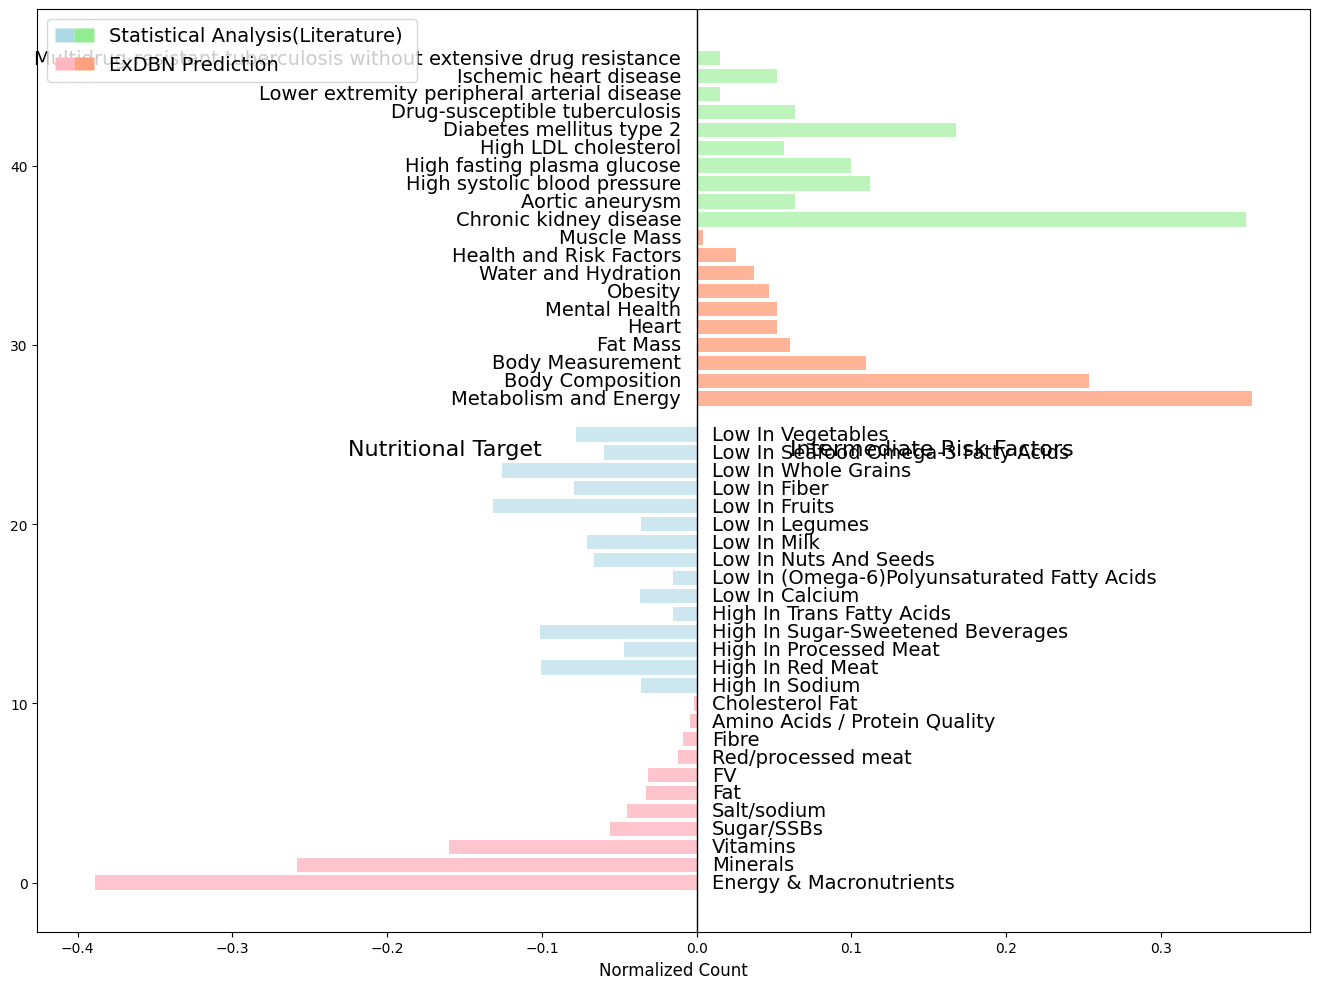

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection

num_cols = nutritional_merged_ExDBN.select_dtypes(include='number').columns
non_num_cols = nutritional_merged_ExDBN.select_dtypes(exclude='number').columns
nutritional_merged = nutritional_merged_ExDBN.copy()
nutritional_merged[num_cols] = nutritional_merged[num_cols] * -1
risk_merged = risk_merged_ExDBN[risk_merged_ExDBN['Label'] != 'Stomach']

left_big = nutritional_merged[['Label', 'Normalized_groundtruth']]
left_small = nutritional_merged[['Label', 'Normalized_ExDBN']]
right_big = risk_merged[['Label', 'Normalized_groundtruth']]
right_small = risk_merged[['Label', 'Normalized_ExDBN']]

max_len = len(nutritional_merged)+len(risk_merged)+1
left_big = pd.concat([left_big, pd.DataFrame({'Label': [''], 'Normalized_groundtruth': ['']} , index=range(len(left_big), max_len))], ignore_index=True)
left_small = pd.concat([left_small, pd.DataFrame({'Label': [''], 'Normalized_ExDBN': ['']}, index=range(len(left_small), max_len))], ignore_index=True)
right_big = pd.concat([pd.DataFrame({'Label': [''], 'Normalized_groundtruth': ['']}, index=range(max_len - len(right_big))), right_big], ignore_index=True)
right_small = pd.concat([pd.DataFrame({'Label': [''], 'Normalized_ExDBN': ['']}, index=range(max_len - len(right_small))), right_small], ignore_index=True)
y = np.arange(max_len)
colors1 = ['lightblue', 'lightgreen']  # Colors for Ground Truth
colors2 = ['lightpink', '#FFA07D']  # Colors for ExDBN Prediction

# 画图
fig, ax = plt.subplots(figsize=(14, 10))
left_big['Normalized_groundtruth'] = pd.to_numeric(left_big['Normalized_groundtruth'], errors='coerce').fillna(0)  # errors='coerce' converts non-numeric to NaN, then fillna(0) fills NaN with 0
left_small['Normalized_ExDBN'] = pd.to_numeric(left_small['Normalized_ExDBN'], errors='coerce').fillna(0)
right_big['Normalized_groundtruth'] = pd.to_numeric(right_big['Normalized_groundtruth'], errors='coerce').fillna(0)
right_small['Normalized_ExDBN'] = pd.to_numeric(right_small['Normalized_ExDBN'], errors='coerce').fillna(0)

ax.barh(y, left_big['Normalized_groundtruth'], color=colors1[0], alpha=0.6)
ax.barh(y, left_small['Normalized_ExDBN'], color=colors2[0], alpha=0.8)
ax.barh(y, right_big['Normalized_groundtruth'], color=colors1[1], alpha=0.6)
ax.barh(y, right_small['Normalized_ExDBN'], color=colors2[1], alpha=0.8)

for i, label in enumerate(left_big['Label']):
    ax.text(0.01, i, label, va='center', ha='left', fontsize=14, color='black')

for i, label in enumerate(right_big['Label']):
    ax.text(-0.01, i, label, va='center', ha='right', fontsize=14, color='black')

ax.text(-0.1, 24.2, 'Nutritional Target', va='center', ha='right', fontsize=16, color='black')
ax.text(0.06, 24.2, 'Intermediate Risk Factors', va='center', ha='left', fontsize=16, color='black')

# x轴标签
ax.set_xlabel('Normalized Count', fontsize=12)
# 中轴线
ax.axvline(0, color='black', linewidth=1)

# 轴和标题
ax.set_xlabel('Normalized Count')
#ax.set_title('Comparison Between Ground Truth and ExDBN Prediction', y=1.05, fontsize=16)

# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors):
        self.colors = colors

# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent,
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height,
                           facecolor=c,
                           edgecolor='none'))

        patch = PatchCollection(patches,match_original=True)

        handlebox.add_artist(patch)
        return patch

h, l = ax.get_legend_handles_labels()

# ------ append the multicolor legend patches
h.append(MulticolorPatch(colors1))
l.append("Statistical Analysis(Literature) ")

h.append(MulticolorPatch(colors2))
l.append("ExDBN Prediction")

ax.legend(h, l, loc='upper left',
         handler_map={MulticolorPatch: MulticolorPatchHandler()},
         #bbox_to_anchor=(1.05, 1),
         fontsize=14) #changed f to ax
# 美化
plt.tight_layout()
plt.show()

## **4.5 Adjacency Matrix**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#Dietary Risks	Intermediate Risks
adj_matrix_ExDBN = summary_df_ExDBN.pivot_table(index='Dietary Risks',observed=True,
                            columns='Intermediate Risks',
                            values='User_Count',
                            fill_value=0)
adj_matrix_Literature = summary_df_Literature.pivot_table(index='Dietary Risks',observed=True,
                            columns='Intermediate Risks',
                            values='Patient_Count',
                            fill_value=0)
all_rows = adj_matrix_ExDBN.index.intersection(adj_matrix_Literature.index)
all_cols = adj_matrix_ExDBN.columns.intersection(adj_matrix_Literature.columns)
adj_matrix_ExDBN = adj_matrix_ExDBN.reindex(index=all_rows, columns=all_cols, fill_value=0)
adj_matrix_ExDBN_scaled = (adj_matrix_ExDBN - adj_matrix_ExDBN.values.mean()) / adj_matrix_ExDBN.values.std()
#print(adj_matrix_ExDBN.head())

## **4.6 Heatmap**

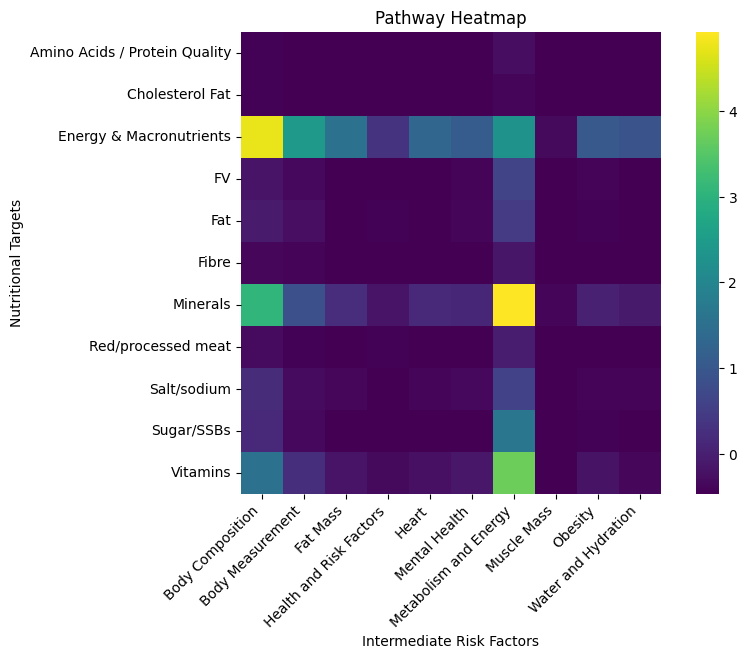

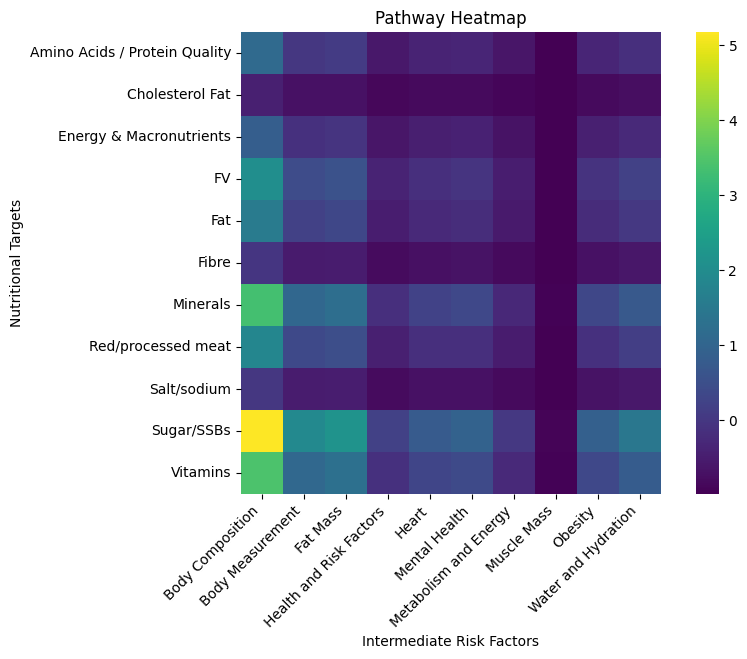

In [ ]:
adj_matrix_Literature = adj_matrix_Literature.reindex(index=all_rows, columns=all_cols, fill_value=0)
adj_matrix_Literature_scaled = (adj_matrix_Literature - adj_matrix_Literature.values.mean()) / adj_matrix_Literature.values.std()#
#print(adj_matrix_Literature.head())

# 设置图形大小
plt.figure(figsize=(9, 6))
sns.heatmap(adj_matrix_ExDBN_scaled, cmap='viridis', annot=False, square=True)
plt.title('Pathway Heatmap')
plt.xlabel('Intermediate Risk Factors')
plt.ylabel('Nutritional Targets')
plt.xticks(rotation=45, ha='right')
plt.show()

plt.figure(figsize=(9, 6))
sns.heatmap(adj_matrix_Literature_scaled, cmap='viridis', annot=False, square=True)
plt.title('Pathway Heatmap')
plt.xlabel('Intermediate Risk Factors')
plt.ylabel('Nutritional Targets')
plt.xticks(rotation=45, ha='right')
plt.show()




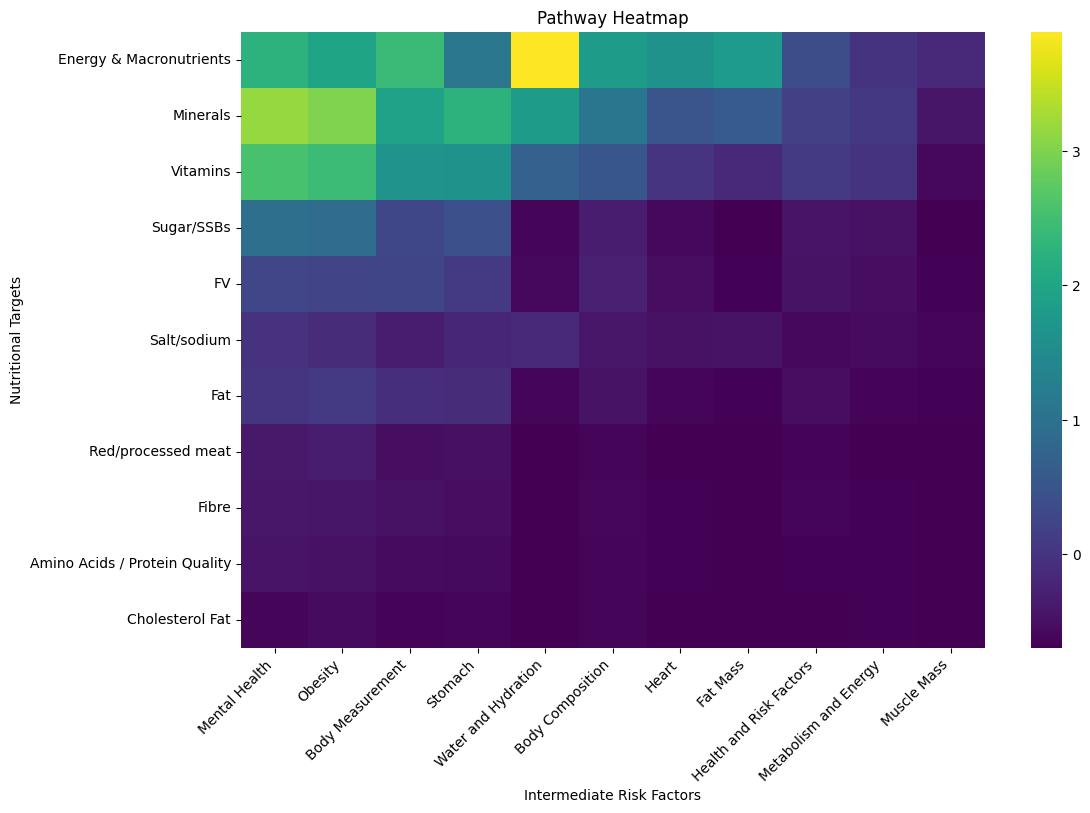

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形大小
plt.figure(figsize=(12, 8))

# 画 heatmap
df_scaled = (adj_matrix_ExDBN - adj_matrix_ExDBN.values.mean()) / adj_matrix_ExDBN.values.std()

sns.heatmap(df_scaled, cmap='viridis', annot=False)

# 设置标题
plt.title('Pathway Heatmap')
plt.xlabel('Intermediate Risk Factors')
plt.ylabel('Nutritional Targets')

plt.xticks(rotation=45, ha='right')

# 显示图形
plt.show()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

adj_matrix_Literature = summary_df_Literature.pivot_table(index='Nutritional_Target',
                            columns='Risk_Factor',
                            values='Patient_Count',
                            fill_value=0)
adj_matrix_Literature = adj_matrix_Literature.reindex(index=all_rows, columns=all_cols, fill_value=0)
print(adj_matrix_Literature)
adj_matrix_Literature.to_csv('adjacency_matrix_Literature.csv')
df_scaled = (adj_matrix_Literature - adj_matrix_Literature.values.mean()) / adj_matrix_Literature.values.std()

plt.figure(figsize=(12, 8))
sns.heatmap(df_scaled, cmap='viridis', annot=False)
plt.title('Pathway Heatmap')
plt.xlabel('Intermediate Risk Factors')
plt.ylabel('Nutritional Targets')
plt.xticks(rotation=45, ha='right')
plt.show()

# **Backup**

## backup 4.2

#### Rank-4.2.1

In [ ]:
# Step 1: Count category number
def count_patient(summary_df):
    summary_df = summary_df.rename(columns={'User_Count': 'Count'})
    summary_df = summary_df.rename(columns={'Patient_Count': 'Count'})

    nutritional_sum = summary_df.groupby('Dietary Risks')['Count'].sum().reset_index()
    nutritional_sum = nutritional_sum.sort_values('Count', ascending=True).reset_index(drop=True)
    nutritional_sum = nutritional_sum.rename(columns={'Dietary Risks': 'Label'})
    risk_sum = summary_df.groupby('Intermediate Risks')['Count'].sum().reset_index()
    risk_sum = risk_sum.sort_values('Count', ascending=True).reset_index(drop=True)
    risk_sum = risk_sum.rename(columns={'Intermediate Risks': 'Label'})
    # print(nutritional_sum, risk_sum)
    return nutritional_sum, risk_sum

nutritional_sum_ExDBN, risk_sum_ExDBN = count_patient(summary_df_ExDBN)
nutritional_sum_groundtruth, risk_sum_groundtruth = count_patient(summary_df_Literature)
# nutritional_merged_ExDBN = nutritional_merged_.sort_values('Normalized_ExDBN', ascending=False).reset_index(drop=True)
# risk_merged_ExDBN = risk_merged_.sort_values('Normalized_ExDBN', ascending=False).reset_index(drop=True)
print(nutritional_sum_ExDBN, risk_sum_ExDBN)
print(nutritional_sum_groundtruth, risk_sum_groundtruth)


                            Label  Count
0                 Cholesterol Fat    244
1   Amino Acids / Protein Quality    574
2                           Fibre   1099
3              Red/processed meat   1544
4                              FV   3965
5                             Fat   4179
6                     Salt/sodium   5703
7                      Sugar/SSBs   7151
8                        Vitamins  20357
9                        Minerals  32824
10        Energy & Macronutrients  49357                      Label  Count
0              Muscle Mass    520
1  Health and Risk Factors   3219
2      Water and Hydration   4704
3                  Obesity   5969
4            Mental Health   6605
5                    Heart   6622
6                 Fat Mass   7690
7         Body Measurement  13921
8         Body Composition  32195
9    Metabolism and Energy  45552
                            Label  Count
0                 Cholesterol Fat   4665
1                           Fibre   7785
2          

In [ ]:
# 按ExDBN排 label的顺序
nutritional_merged_ExDBN = nutritional_sum_ExDBN.sort_values('Count', ascending=False).reset_index(drop=True)
risk_merged_ExDBN = risk_sum_ExDBN.sort_values('Count', ascending=False).reset_index(drop=True)
ExDBN_nutritional_order = nutritional_merged_ExDBN.Label.tolist()
ExDBN_risk_order = risk_merged_ExDBN.Label.tolist()

# 按Literature排 label的顺序
nutritional_merged_groundtruth = nutritional_sum_groundtruth.sort_values('Count', ascending=False).reset_index(drop=True)
risk_merged_groundtruth = risk_sum_groundtruth.sort_values('Count', ascending=False).reset_index(drop=True)
Literature_nutritional_order = nutritional_merged_groundtruth.Label.tolist()
Literature_risk_order = risk_merged_groundtruth.Label.tolist()


#### Normalize Rank-4.2.1

In [ ]:
# Step 1: Count category number
def count_patient(summary_df):
    summary_df = summary_df.rename(columns={'Normalized_User': 'Count'})
    summary_df = summary_df.rename(columns={'Normalized_Patient': 'Count'})

    nutritional_sum = summary_df.groupby('Dietary Risks')['Count'].sum().reset_index()
    nutritional_sum = nutritional_sum.sort_values('Count', ascending=True).reset_index(drop=True)
    nutritional_sum = nutritional_sum.rename(columns={'Dietary Risks': 'Label'})
    risk_sum = summary_df.groupby('Intermediate Risks')['Count'].sum().reset_index()
    risk_sum = risk_sum.sort_values('Count', ascending=True).reset_index(drop=True)
    risk_sum = risk_sum.rename(columns={'Intermediate Risks': 'Label'})
    # print(nutritional_sum, risk_sum)
    return nutritional_sum, risk_sum

nutritional_sum_ExDBN, risk_sum_ExDBN = count_patient(summary_df_ExDBN)
nutritional_sum_groundtruth, risk_sum_groundtruth = count_patient(summary_df_Literature)
# nutritional_merged_ExDBN = nutritional_merged_.sort_values('Normalized_ExDBN', ascending=False).reset_index(drop=True)
# risk_merged_ExDBN = risk_merged_.sort_values('Normalized_ExDBN', ascending=False).reset_index(drop=True)
print(nutritional_sum_ExDBN, risk_sum_ExDBN)
print(nutritional_sum_groundtruth, risk_sum_groundtruth)


                            Label       Count
0              Red/processed meat   28.105833
1   Amino Acids / Protein Quality   29.892361
2                 Cholesterol Fat   45.111111
3                              FV   73.967516
4                      Sugar/SSBs   81.265850
5                           Fibre  100.383333
6                             Fat  115.362119
7                        Vitamins  176.764588
8                        Minerals  360.559904
9                     Salt/sodium  423.920261
10        Energy & Macronutrients  843.008960                      Label        Count
0      Water and Hydration    60.037749
1                 Fat Mass    66.274761
2  Health and Risk Factors    74.249703
3              Muscle Mass    78.264957
4                    Heart    81.073741
5                  Obesity   104.939439
6            Mental Health   121.191032
7         Body Composition   124.352346
8         Body Measurement   130.658964
9    Metabolism and Energy  1437.299145
        

In [ ]:
# 按ExDBN排 label的顺序
nutritional_merged_ExDBN = nutritional_sum_ExDBN.sort_values('Count', ascending=False).reset_index(drop=True)
risk_merged_ExDBN = risk_sum_ExDBN.sort_values('Count', ascending=False).reset_index(drop=True)
ExDBN_nutritional_order = nutritional_merged_ExDBN.Label.tolist()
ExDBN_risk_order = risk_merged_ExDBN.Label.tolist()

# 按Literature排 label的顺序
nutritional_merged_groundtruth = nutritional_sum_groundtruth.sort_values('Count', ascending=False).reset_index(drop=True)
risk_merged_groundtruth = risk_sum_groundtruth.sort_values('Count', ascending=False).reset_index(drop=True)
Literature_nutritional_order = nutritional_merged_groundtruth.Label.tolist()
Literature_risk_order = risk_merged_groundtruth.Label.tolist()


#### Normalize and rank-4.2.1

In [ ]:
# Step 1: Count category number
def count_patient(summary_df):
    summary_df = summary_df.rename(columns={'User_Count': 'Count'})
    summary_df = summary_df.rename(columns={'Patient_Count': 'Count'})

    nutritional_sum = summary_df.groupby('Dietary Risks')['Count'].sum().reset_index()
    nutritional_sum = nutritional_sum.sort_values('Count', ascending=True).reset_index(drop=True)
    nutritional_sum = nutritional_sum.rename(columns={'Dietary Risks': 'Label'})
    risk_sum = summary_df.groupby('Intermediate Risks')['Count'].sum().reset_index()
    risk_sum = risk_sum.sort_values('Count', ascending=True).reset_index(drop=True)
    risk_sum = risk_sum.rename(columns={'Intermediate Risks': 'Label'})
    # print(nutritional_sum, risk_sum)
    return nutritional_sum, risk_sum

nutritional_sum_ExDBN, risk_sum_ExDBN = count_patient(summary_df_ExDBN)
nutritional_sum_groundtruth, risk_sum_groundtruth = count_patient(summary_df_Literature)
# nutritional_merged_ExDBN = nutritional_merged_.sort_values('Normalized_ExDBN', ascending=False).reset_index(drop=True)
# risk_merged_ExDBN = risk_merged_.sort_values('Normalized_ExDBN', ascending=False).reset_index(drop=True)
print(nutritional_sum_ExDBN, risk_sum_ExDBN)
print(nutritional_sum_groundtruth, risk_sum_groundtruth)

# Step 2: Normalize
def normalize(df):
    df['Normalized'] = df['Count'] / df['Count'].sum()
    return df

nutritional_sum_ExDBN = normalize(nutritional_sum_ExDBN)
nutritional_sum_groundtruth = normalize(nutritional_sum_groundtruth)
risk_sum_ExDBN = normalize(risk_sum_ExDBN)
risk_sum_groundtruth = normalize(risk_sum_groundtruth)

# Step 3: Outer merge nutritional tables
nutritional_merged_ = pd.merge(
    nutritional_sum_groundtruth[['Label', 'Normalized']],
    nutritional_sum_ExDBN[['Label', 'Normalized']],
    on='Label',
    how='outer',
    suffixes=('_groundtruth', '_ExDBN')
).fillna(0)

# Step 4: Outer merge risk tables
risk_merged_ = pd.merge(
    risk_sum_groundtruth[['Label', 'Normalized']],
    risk_sum_ExDBN[['Label', 'Normalized']],
    on='Label',
    how='outer',
    suffixes=('_groundtruth', '_ExDBN')
).fillna(0)



                            Label  Count
0                 Cholesterol Fat    244
1   Amino Acids / Protein Quality    574
2                           Fibre   1099
3              Red/processed meat   1544
4                              FV   3965
5                             Fat   4179
6                     Salt/sodium   5703
7                      Sugar/SSBs   7151
8                        Vitamins  20357
9                        Minerals  32824
10        Energy & Macronutrients  49357                      Label  Count
0              Muscle Mass    520
1  Health and Risk Factors   3219
2      Water and Hydration   4704
3                  Obesity   5969
4            Mental Health   6605
5                    Heart   6622
6                 Fat Mass   7690
7         Body Measurement  13921
8         Body Composition  32195
9    Metabolism and Energy  45552
                            Label  Count
0                 Cholesterol Fat   4665
1                           Fibre   7785
2          

In [ ]:
# Step 4: Rank Labels
## 按 ExDBN排 label的顺序
nutritional_merged_ExDBN = nutritional_merged_.sort_values('Normalized_ExDBN', ascending=False).reset_index(drop=True)
risk_merged_ExDBN = risk_merged_.sort_values('Normalized_ExDBN', ascending=False).reset_index(drop=True)
ExDBN_nutritional_order = nutritional_merged_ExDBN.Label.tolist()
ExDBN_risk_order = risk_merged_ExDBN.Label.tolist()

# 按Literature排 label的顺序
nutritional_merged_groundtruth = nutritional_merged_.sort_values('Normalized_groundtruth', ascending=False).reset_index(drop=True)
risk_merged_groundtruth = risk_merged_.sort_values('Normalized_groundtruth', ascending=False).reset_index(drop=True)
Literature_nutritional_order = nutritional_merged_groundtruth.Label.tolist()
Literature_risk_order = risk_merged_groundtruth.Label.tolist()


In [ ]:
nutritional_merged_ExDBN = nutritional_merged_.sort_values('Normalized_ExDBN', ascending=False).reset_index(drop=True)
risk_merged_ExDBN = risk_merged_.sort_values('Normalized_ExDBN', ascending=False).reset_index(drop=True)
ExDBN_nutritional_order = nutritional_merged_ExDBN.Label.tolist()
risk_merged_ExDBN = risk_merged_.sort_values('Normalized_ExDBN', ascending=False).reset_index(drop=True)
ExDBN_risk_order = risk_merged_ExDBN.Label.tolist()
print(ExDBN_nutritional_order)
ExDBN_risk_order_df = pd.DataFrame(ExDBN_risk_order, columns=['Label'])
ExDBN_risk_order_df = ExDBN_risk_order_df[ExDBN_risk_order_df['Label'] != 'Stomach']
ExDBN_risk_order = ExDBN_risk_order_df['Label'].tolist()
print(ExDBN_risk_order)

nutritional_merged_groundtruth = nutritional_merged_.sort_values('Normalized_groundtruth', ascending=False).reset_index(drop=True)
risk_merged_groundtruth = risk_merged_.sort_values('Normalized_groundtruth', ascending=False).reset_index(drop=True)
Literature_nutritional_order = nutritional_merged_groundtruth.Label.tolist()
Literature_risk_order = risk_merged_groundtruth.Label.tolist()

Literature_risk_order_df = pd.DataFrame(Literature_risk_order, columns=['Label'])
Literature_risk_order_df = Literature_risk_order_df[Literature_risk_order_df['Label'] != 'Stomach']
Literature_risk_order = Literature_risk_order_df['Label'].tolist()

print(Literature_nutritional_order)
print(Literature_risk_order)

['Energy & Macronutrients', 'Minerals', 'Vitamins', 'Sugar/SSBs', 'Salt/sodium', 'Fat', 'FV', 'Red/processed meat', 'Fibre', 'Amino Acids / Protein Quality', 'Cholesterol Fat']
['Metabolism and Energy', 'Body Composition', 'Body Measurement', 'Fat Mass', 'Heart', 'Mental Health', 'Obesity', 'Water and Hydration', 'Health and Risk Factors', 'Muscle Mass']
['Sugar/SSBs', 'Vitamins', 'Minerals', 'FV', 'Red/processed meat', 'Fat', 'Amino Acids / Protein Quality', 'Energy & Macronutrients', 'Salt/sodium', 'Fibre', 'Cholesterol Fat']
['Body Composition', 'Fat Mass', 'Body Measurement', 'Water and Hydration', 'Mental Health', 'Obesity', 'Heart', 'Health and Risk Factors', 'Metabolism and Energy', 'Muscle Mass']


#### Change Summaries-4.2.2

In [ ]:
# 将 Dietary Risks 设置为有序类别
summary_df_ExDBN['Dietary Risks'] = pd.Categorical(
    summary_df_ExDBN['Dietary Risks'],
    categories=ExDBN_nutritional_order,
    ordered=True
)
# 将 Risk_Factor 设置为有序类别
summary_df_ExDBN['Intermediate Risks'] = pd.Categorical(
    summary_df_ExDBN['Intermediate Risks'],
    categories=ExDBN_risk_order,
    ordered=True
)
#summary_df_ExDBN = summary_df_ExDBN.sort_values('Dietary Risks')
#summary_df_ExDBN_sorted = summary_df_ExDBN.sort_values('Intermediate Risks')
summary_df_ExDBN_sorted = summary_df_ExDBN.sort_values(['Dietary Risks', 'Intermediate Risks']).reset_index(drop=True)
summary_df_ExDBN_sorted

# 将 Nutritional_Target 设置为有序类别
summary_df_Literature['Dietary Risks'] = pd.Categorical(
    summary_df_Literature['Dietary Risks'],
    categories=Literature_nutritional_order,
    ordered=True
)
summary_df_Literature['Intermediate Risks'] = pd.Categorical(
    summary_df_Literature['Intermediate Risks'],
    categories=Literature_risk_order,
    ordered=True
)

# summary_df_Literature = summary_df_Literature.sort_values('Dietary Risks')
#summary_df_Literature_sorted = summary_df_Literature.sort_values('Intermediate Risks')
summary_df_Literature_sorted = summary_df_Literature.sort_values(['Dietary Risks', 'Intermediate Risks']).reset_index(drop=True)
summary_df_Literature_sorted

,Dietary Risks,Intermediate Risks,Patient_Count,Normalized_Patient
0,Sugar/SSBs,Body Composition,13956,22.803922
1,Sugar/SSBs,Fat Mass,7162,24.782007
2,Sugar/SSBs,Body Measurement,6586,25.827451
3,Sugar/SSBs,Water and Hydration,5546,27.186275
4,Sugar/SSBs,Mental Health,4364,32.088235
...,...,...,...,...
105,Cholesterol Fat,Obesity,381,47.625000
106,Cholesterol Fat,Heart,370,30.833333
107,Cholesterol Fat,Health and Risk Factors,250,41.666667
108,Cholesterol Fat,Metabolism and Energy,210,52.500000


### Dietary→ Intermediate → Outcomes

In [20]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

pathway_counts= grouped_df

all_nodes = (
    pathway_counts['Nutritional_Target'].unique().tolist() +
    pathway_counts['Risk_Factor'].unique().tolist() +
    pathway_counts['Outcome'].unique().tolist()
)

# Create node indices
node_indices = {node: idx for idx, node in enumerate(all_nodes)}

# Create source-target-value lists for the Sankey diagram
sources = []
targets = []
values = []
labels = all_nodes.copy()

# First connection: Nutritional Target -> Intermediate Risk Factor
for _, row in pathway_counts.iterrows():
    sources.append(node_indices[row['Nutritional_Target']])
    targets.append(node_indices[row['Risk_Factor']])
    values.append(row['Patient_Count'])

# Second connection: Intermediate Risk Factor -> Outcome
for _, row in pathway_counts.iterrows():
    sources.append(node_indices[row['Risk_Factor']])
    targets.append(node_indices[row['Outcome']])
    values.append(row['Patient_Count'])

# 3. Create Color Mapping
# -----------------------
nutritional_targets = pathway_counts['Nutritional_Target'].unique().tolist()
intermediate_factors = pathway_counts['Risk_Factor'].unique().tolist()
outcomes = pathway_counts['Outcome'].unique().tolist()

# Color nodes by their type
node_colors = []
for node in all_nodes:
    if node in nutritional_targets:
        node_colors.append('#636EFA')  # Blue for nutritional targets
    elif node in intermediate_factors:
        node_colors.append('#EF553B')  # Red for intermediate factors
    else:
        node_colors.append('#00CC96')  # Green for outcomes

# Color links based on their target (outcome)
link_colors = []
for target in targets:
    if all_nodes[target] in outcomes:
        # Map outcomes to specific colors
        outcome_colors = {
            'Diabetes': '#1f77b4',
            'Cancer': '#ff7f0e',
            'Caries': '#2ca02c',
            'Cirrhosis': '#d62728',
            'CVD': '#9467bd',#(Cardiovascular Disease)
            'Obesity': '#8c564b',
            'Osteoarthritis': '#e377c2',
            'QALY': '#7f7f7f',#(Quality-Adjusted Life Year)
            'Stroke': '#bcbd22'
        }
        link_colors.append(outcome_colors.get(all_nodes[target], 'rgba(200,200,200,0.5)'))
    else:
        link_colors.append('rgba(200,200,200,0.5)')

# 4. Create Sankey Diagram
# ------------------------
fig = go.Figure(go.Sankey(
    arrangement="snap",
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.4),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors
    )
))

# Update layout
fig.update_layout(
    title_text=" Nutritional Pathways from Targets to Outcomes Based on 5308 Modeling Studies",
    font_size=12,
    height=800,
    annotations=[
        dict(
            x=-0.05, y=1.05,
            xref='paper', yref='paper',
            text='Nutritional Targets',
            showarrow=False,
            font_size=14
        ),
        dict(
            x=0.5, y=1.05,
            xref='paper', yref='paper',
            text='Intermediate Risk Factors',
            showarrow=False,
            font_size=14
        ),
        dict(
            x=1.0, y=1.05,
            xref='paper', yref='paper',
            text='Outcomes',
            showarrow=False,
            font_size=14
        )
    ]
)

# Show the figure
fig.show()

# Save to HTML file
# fig.write_html("nutritional_pathways_sankey.html")
fig.write_image("./Results/ExDBN-NutritionalData/ExDBN-CoDiet-Intake24-Biosensor-plots/nutritional_pathways_sankey.png")

NameError: name 'grouped_df' is not defined

## Pseudotime analysis

*  Run in MIP4Cluster

See [Test Pseudotime-trace](https://colab.research.google.com/drive/1mJ1wig2skX5MohsQdnImC1MIMFv_LwYl#scrollTo=BINwValOaaPo)


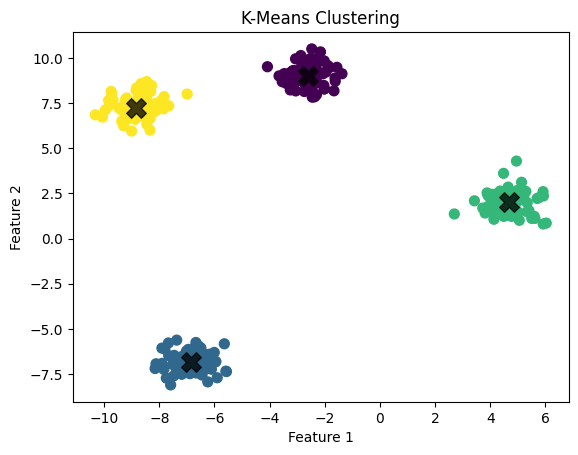

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# 生成模拟数据
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.6, random_state=42)

# 聚类
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# 可视化结果
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75, marker='X')
plt.title("K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


## Silhouette Plot

* 轮廓系数图，用于评估聚类的效果。这个图显示了每个数据点的轮廓系数，以及每个聚类的平均轮廓系数。

<img src="https://raw.githubusercontent.com/sereneHe/Causal-Models-Learning/main/images/silhouette.png" alt="silhouette" width="300"/>

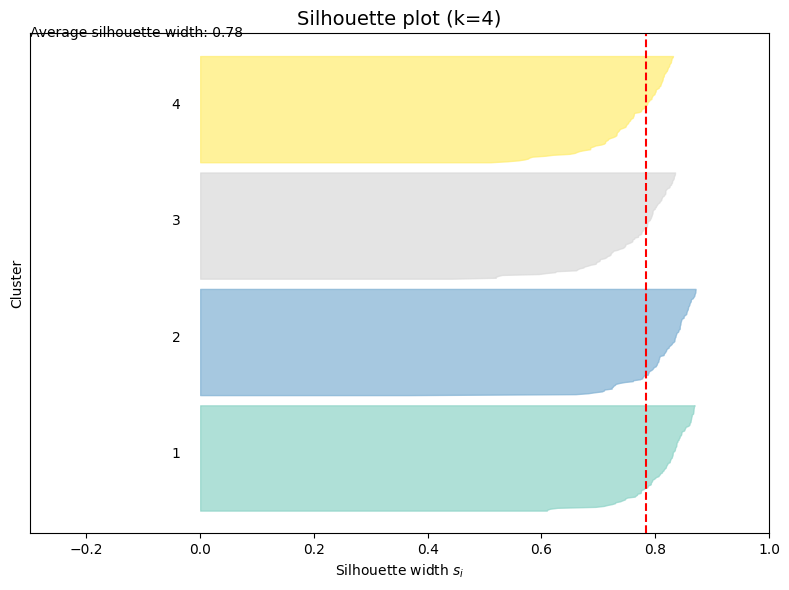

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# 生成示例数据
X, _ = make_blobs(n_samples=459, n_features=2, centers=4, cluster_std=1.0, random_state=10)

# 聚类
k = 4
clusterer = KMeans(n_clusters=k, random_state=10)
cluster_labels = clusterer.fit_predict(X)

# 计算轮廓系数
silhouette_vals = silhouette_samples(X, cluster_labels)
avg_score = silhouette_score(X, cluster_labels)

# 创建图形
fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10
colors = plt.cm.Set3(np.linspace(0, 1, k))

for i in range(k):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    color = colors[i]
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouette_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)

    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i + 1))
    y_lower = y_upper + 10  # 为下一个簇留出空隙

# 平均轮廓系数线
ax.axvline(x=avg_score, color="red", linestyle="--")
ax.set_title(f"Silhouette plot (k={k})", fontsize=14)
ax.set_xlabel("Silhouette width $s_i$")
ax.set_ylabel("Cluster")
ax.set_yticks([])  # 隐藏y轴标签
ax.set_xlim([-0.3, 1])
ax.text(-0.3, y_lower + 10, f"Average silhouette width: {avg_score:.2f}")

plt.tight_layout()
plt.show()


## 散点图和堆叠柱状图

<img src="https://raw.githubusercontent.com/sereneHe/Causal-Models-Learning/main/images/cluster_Pseudotime.png" alt="cluster_Pseudotime" width="300"/>
<img src="https://raw.githubusercontent.com/sereneHe/Causal-Models-Learning/main/images/barplot.png" alt="barplot" width="300"/>

In [ ]:
!pip install scanpy igraph leidenalg fa2-modified

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fa2-modified: filename=fa2_modified-0.3.10-cp311-cp311-linux_x86_64.whl size=465110 sha256=c86ec49496a9b12e22efecc7d56396b4e89ae45effb5ed05e92e4bdc2e05acc7
  Stored in directory: /root/.cache/pip/wheels/81/b2/15/8a423eede3a6c1c71ef380530715a08c0c87f4a51659adae18
Successfully built fa2-modified


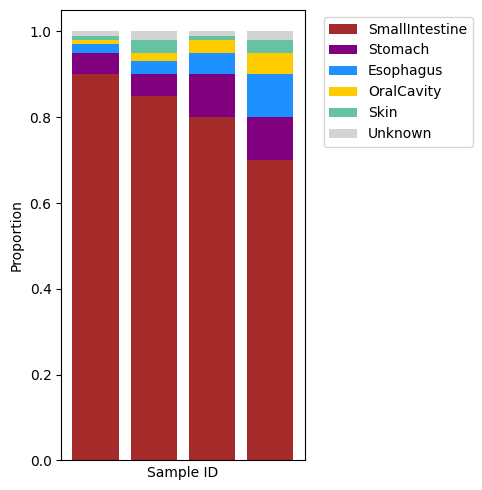

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 示例数据结构（你应替换为实际数据）
data = pd.DataFrame({
    'SmallIntestine': [0.9, 0.85, 0.8, 0.7],
    'Stomach':        [0.05, 0.05, 0.1, 0.1],
    'Esophagus':      [0.02, 0.03, 0.05, 0.1],
    'OralCavity':     [0.01, 0.02, 0.03, 0.05],
    'Skin':           [0.01, 0.03, 0.01, 0.03],
    'Unknown':        [0.01, 0.02, 0.01, 0.02]
})
data.index = [f"Sample{i}" for i in range(len(data))]

# 颜色顺序和图例保持一致
colors = {
    'SmallIntestine': '#a52a2a',
    'Stomach': '#800080',
    'Esophagus': '#1e90ff',
    'OralCavity': '#ffcc00',
    'Skin': '#66c2a5',
    'Unknown': '#d3d3d3'
}

# 绘制堆叠柱状图
fig, ax = plt.subplots(figsize=(5, 5))
bottom = [0] * len(data)

for tissue in colors:
    ax.bar(data.index, data[tissue], bottom=bottom, label=tissue, color=colors[tissue])
    bottom = [i + j for i, j in zip(bottom, data[tissue])]

ax.set_ylabel("Proportion")
ax.set_xlabel("Sample ID")
ax.set_xticks([])
ax.legend(title="", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


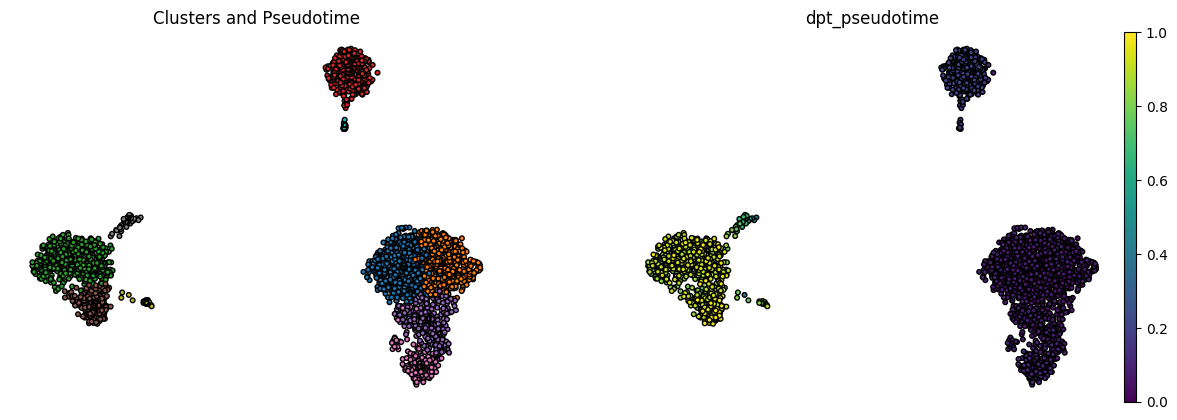

In [ ]:
import scanpy as sc

# 载入数据（你可以替换为你自己的数据）
adata = sc.datasets.pbmc3k()

# 数据预处理
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable].copy()  # 避免视图警告
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

# 聚类
sc.tl.leiden(adata)

# 拟时分析（设置 root cell）
sc.tl.diffmap(adata)
root_cell = adata.obs[adata.obs['leiden'] == '0'].index[0]
adata.uns['iroot'] = adata.obs_names.get_loc(root_cell)
sc.tl.dpt(adata)

sc.pl.umap(adata, color=['leiden', 'dpt_pseudotime'], legend_loc='on data',
           edgecolor='k', title='Clusters and Pseudotime', frameon=False)


## Coinrunner

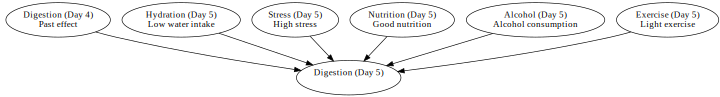

In [ ]:
from typing import List, Tuple
from graphviz import Digraph


# 新增变量：酒精摄入（Alcohol），运动习惯（Exercise）
# 模拟一个结构因果模型中的变量及其因果影响关系
# 每项为 (Parent, Child, Influence Description, Effect Direction)
causal_edges: List[Tuple[str, str, str, str]] = [
    ("Digestion (Day 4)", "Digestion (Day 5)", "Past effect", "⬇️"),
    ("Hydration (Day 5)", "Digestion (Day 5)", "Low water intake", "⬇️"),
    ("Stress (Day 5)", "Digestion (Day 5)", "High stress", "⬇️"),
    ("Nutrition (Day 5)", "Digestion (Day 5)", "Good nutrition", "⬆️"),
    ("Alcohol (Day 5)", "Digestion (Day 5)", "Alcohol consumption", "⬇️"),
    ("Exercise (Day 5)", "Digestion (Day 5)", "Light exercise", "⬆️"),
]

# 构建解释树图像
dot = Digraph(comment='T-SCE Expanded Explanation Tree')
dot.attr(rankdir='TB', size='10')

# 添加目标节点
dot.node('D5', 'Digestion (Day 5)\n⬇️ 低于平均')

# 添加因果父节点和边
for parent, child, label, symbol in causal_edges:
    node_id = parent.split()[0][:1] + parent.split()[1]  # unique ID (e.g., D4, H5)
    dot.node(node_id, f"{parent}\n{symbol} {label}")
    dot.edge(node_id, 'D5')# , label=label

# 渲染图像
dot.render('/mnt/data/t_sce_digestion_tree_expanded', format='png', cleanup=False)
'/mnt/data/t_sce_digestion_tree_expanded.png'

dot.view()  # 在本地打开图像文件
dot  # 在 Jupyter Notebook 中直接渲染输出

### **R Plot**

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# 读取数据
df = pd.read_csv("./Results/ExDBN-NutritionalData/plot_data.csv")  # 请改为你的文件路径

# 分组统计
grouped = df.groupby(["Nutritional_Target", "Risk_Factor", "Outcome"])["User ID"].nunique().reset_index()
grouped = grouped.rename(columns={"User ID": "Value"})

# 创建节点标签
labels = pd.unique(grouped[["Nutritional_Target", "Risk_Factor", "Outcome"]].values.ravel())
label_to_index = {label: idx for idx, label in enumerate(labels)}

# Nutritional_Target -> Risk_Factor
links1 = grouped.groupby(["Nutritional_Target", "Risk_Factor"])["Value"].sum().reset_index()
links1["source"] = links1["Nutritional_Target"].map(label_to_index)
links1["target"] = links1["Risk_Factor"].map(label_to_index)

# Risk_Factor -> Outcome
links2 = grouped.groupby(["Risk_Factor", "Outcome"])["Value"].sum().reset_index()
links2["source"] = links2["Risk_Factor"].map(label_to_index)
links2["target"] = links2["Outcome"].map(label_to_index)

# 合并链接
all_links = pd.concat([
    links1[["source", "target", "Value"]],
    links2[["source", "target", "Value"]]
])

# 创建桑基图
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(label_to_index.keys()),
        color="lightblue"
    ),
    link=dict(
        source=all_links["source"],
        target=all_links["target"],
        value=all_links["Value"]
    )
)])

# 保存为 HTML 文件
fig.write_html("round_sankey_plot.html")
print("生成完成：round_sankey_plot.html")


FileNotFoundError: [Errno 2] No such file or directory: 'plot_data.csv'

**Julia~**
https://plotly.com/julia/sankey-diagram/

*  Carbonated Drinks Analysis

## Carbonated drinks Data

In [ ]:
# 全部转小写后筛选
df['drinks'] = df['Search term'].str.lower()

# 包含碳酸饮料关键词
carbonated_keywords = ['fizzy', 'carbonated', 'cola', 'soda', 'soft drink', 'sparkling', ]
mask = df['food_desc_lower'].str.contains('|'.join(carbonated_keywords), na=False)

# 筛选出碳酸饮料记录
df_carbonated = df[mask]


KeyError: 'Food Name'

In [ ]:
# Step 1: Filter for carbonated drink records
# Let's identify relevant entries by looking for keyword matches in 'Description (en)' or 'Food group (en)'

# Convert to lowercase for robust matching
df['Description (en)_lower'] = df['Description (en)'].str.lower()
df['Food group (en)_lower'] = df['Food group (en)'].str.lower()

# Define keywords for carbonated drinks
carbonated_keywords = ['cola', 'fizzy', 'carbonated', 'soft drink', 'soda', 'coke', 'pepsi', 'fanta', 'sprite']

# Function to detect if any keyword is in the string
def contains_any_keyword(text, keywords):
    if pd.isnull(text):
        return False
    return any(keyword in text for keyword in keywords)

# Filter rows where either column contains a keyword
df_carbonated = df[
    df['Description (en)_lower'].apply(lambda x: contains_any_keyword(x, carbonated_keywords)) |
    df['Food group (en)_lower'].apply(lambda x: contains_any_keyword(x, carbonated_keywords))
]

# Step 2: Group by User and calculate total intake & metabolic indicators
df_user_summary = df_carbonated.groupby('User ID').agg({
    'Portion size (g/ml)': 'sum',
    'Energy (kcal)': 'sum',
    'Fat': 'sum',
    'Carbohydrate': 'sum',
    'Protein': 'sum',
    'Total sugars': 'sum'
}).rename(columns={
    'Portion size (g/ml)': 'Total Drink Intake (g/ml)',
    'Energy (kcal)': 'Total Energy (kcal)',
    'Fat': 'Total Fat (g)',
    'Carbohydrate': 'Total Carbohydrate (g)',
    'Protein': 'Total Protein (g)',
    'Total sugars': 'Total Sugars (g)'
}).reset_index()

# Show the summary table
df_user_summary.head()
